# SURFER v3.0

**Author** : Victor Couplet

SURFER is a reduced complexity model with a process-based carbon cycle that can reliably predict CO2 concentrations, global mean temperatures, sea-level rise, and many ocean acidification metrics on timescales from decades to millions of years. SURFER v3.0 is an extension of SURFER v2.0 that incorporates sediments and weathering feedbacks in the carbon cycle component.

This notebook presents the code for the model decribed in [], as well as the code for the figures. 

## Python packages

In [32]:
import numpy as np
import os 
import xarray as xr

from math import floor,log10
from timeit import default_timer as timer
from numba import jit

from scipy.integrate import solve_ivp, odeint
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmcrameri.cm as cmc


## Setup

Files containing data necessary for running SURFER are available in the folder SURFER_v3 available on [url_link] In the cell below, please enter the path to where you downloaded the folder SURFER_v3 on your machine.

In [33]:
base_path = 'C:\\Users\\AL000111\\Documents\\Mémoire\\Code_SURFERv3.0_preprint'

By default, the figures produces in this notebook will be saved in `SURFER_v3/figures` repository. You can specify another path if you want.

In [34]:
# default
figures_path = os.path.join(base_path, '\\SURFER_v3\\figures\\')

# custom path
# figures_path = '/custom/path/for/figures/'

## Emission scenarios 

In the following cell, we define the emissions scenarios that will be used in our experiments. The historical CO$_2$ data is from the Global Carbon Budget (GCB) [(Friedliegstein et al., 2022)](https://essd.copernicus.org/articles/14/4811/2022/), the historical CH$_4$ data is from [Jones et al. (2023)](https://www.nature.com/articles/s41597-023-02041-1). Emissions for the SSP scenarios are taken from the [SSP database](https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=50) hosted by the IIASA.

In [35]:
# Historical emissions

GCB = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/carbon_budget.csv'), delimiter=',')
np.nan_to_num(GCB, copy=False, nan=0.0)

x = np.concatenate(([1750],GCB[100:,0]),axis=0)
y = np.concatenate(([0.0],GCB[100:,2]),axis=0)
landuse_emissions = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)
fossil_emissions = interpolate.interp1d(GCB[:,0],GCB[:,1]-GCB[:,6],bounds_error= False, fill_value=0) # we include cement carbonation sink in fossil emissions

# Emissions for SSP scenarios. Formatted for SURFER

CO2_fossil = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/co2_fossil.csv'), delimiter=',')
CO2_landuse = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/co2_landuse.csv'), delimiter=',')
CH4_fossil = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/ch4_fossil.csv'), delimiter=',')
CH4_landuse = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/ch4_landuse.csv'), delimiter=',')

def emissions_ssp(k):
    time = np.linspace(1750,2301,2301-1750+1)
    emissions = np.zeros((6,2301-1750+1))
    emissions[0] = time
    emissions[1] = CO2_fossil[k]
    emissions[2] = CO2_landuse[k]
    emissions[3] = CH4_fossil[k]
    emissions[4] = CH4_landuse[k]
    return emissions

def emissions_ssp_CO2only(k):
    time = np.linspace(1750,2301,2301-1750+1)
    emissions = np.zeros((6,2301-1750+1))
    emissions[0] = time
    emissions[1] = CO2_fossil[k]
    emissions[2] = CO2_landuse[k]
    return emissions

time = np.linspace(1750,2301,2301-1750+1)
CO2_fossil_ssp = []
CO2_landuse_ssp = []
CH4_fossil_ssp = []
CH4_landuse_ssp = []

for i in range(0,6):
    CO2_fossil_ssp.append(interpolate.interp1d(time,CO2_fossil[i],bounds_error= False, fill_value=0))
    CO2_landuse_ssp.append(interpolate.interp1d(time,CO2_landuse[i],bounds_error= False, fill_value=0))
    CH4_fossil_ssp.append(interpolate.interp1d(time,CH4_fossil[i],bounds_error= False, fill_value=0))
    CH4_landuse_ssp.append(interpolate.interp1d(time,CH4_landuse[i],bounds_error= False, fill_value=0))

zero_emissions = np.zeros((6,2))
zero_emissions[0]= np.array([1750,10000])

# Other emission scenarios

def emissions_logistic(t,toemit,emitted,emitting):
    total = toemit + emitted
    a= -emitting/(toemit*emitted)
    F = (total*toemit*np.exp(a*total*t))/(toemit*np.exp(a*total*t)+emitted)
    E = -a*F*(total-F)
    return E

def forcingCO2(tswitch,toemit,**kwargs):
    
    t=np.linspace(0,3000-tswitch,3000-tswitch+1)
    time = np.linspace(1750,tswitch,tswitch-1750+1)
    hist_em = fossil_emissions(time)
    
    if kwargs['landuse'] == True : 
        hist_em = fossil_emissions(time)+landuse_emissions(time)

    emitting = hist_em[-1]
    emitted = np.sum(hist_em)
    
    if kwargs['mode'] == 'add' : 
        total_toemit = toemit +emitting/2 # emitting/2 is a correction factor to get integrals right
    else : total_toemit = toemit-emitted +emitting/2
    
    x = emissions_logistic(t,total_toemit,emitted,emitting) 
    em = np.concatenate([hist_em,x[1:]])       
    t_em = np.concatenate([time,t[1:]+tswitch])

    emissions = np.zeros((6,len(t_em)))
    emissions[0] = t_em-1750+kwargs['origin']
    emissions[1] = em
    emissions[1:,-2:] = 0 
    
    return emissions

## SURFER v3.0

We first define some parameters linked to physical properties and the geometry of the model. A priori, these paremters are fixed and do not need to be changed by the user.

In [36]:
# Physics

mA=1.727*10**20
mO=7.8*10**22
carbon_molar_mass=12*10**-3
water_molar_mass=18*10**-3
cvol = 0.13
R = 83.14462 # bar*cm3/mol*K

# Geometry

hu=150
hi=500
hd=3150

WU=mO*water_molar_mass*hu/(hu+hi+hd)
WI=mO*water_molar_mass*hi/(hu+hi+hd)
WD=mO*water_molar_mass*hd/(hu+hi+hd)

ZU = hu/2
ZI = hu+hi/2
ZD = hu+hi+hd/2

Aocean = mO*water_molar_mass/1026/(hu+hi+hd)

print('Ocean area is',Aocean/10**12,'10^6 km^2')

Ocean area is 360.1108033240998 10^6 km^2


We then define helping functions. Most of the functions are decorated with the numba @jit decorator, for increased speed. 

In [37]:
# Solubility and dissociation constants with temperature and pressure (depth) dependence

@jit
def k0(T,S) :
     return np.exp(-60.2409+93.4517*(100/T)+23.3585*np.log(T/100)+S*(0.023517-0.023656*(T/100)+0.0047036*(T/100)**2))

@jit
def k1_p(T,S,z) : 
    TC = T-273.15
    mlog10k1 = -62.008+3670.7/T+9.7944*np.log(T)-0.0118*S+0.000116*S**2
    k1_0 = 10**-mlog10k1
    dV = -25.5 + 0.1271*TC
    dK = (-3.08 + 0.0877*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return k1_0*np.exp(C)

@jit
def k2_p(T,S,z) : 
    TC = T-273.15
    mlog10k2 = 4.777+1394.7/T-0.0184*S+0.000118*S**2
    k2_0 = 10**-mlog10k2
    dV = -15.82 - 0.0219*TC
    dK = (1.13 - 0.1475*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return k2_0*np.exp(C)

@jit
def kW_p(T,S,z) : 
    TC = T-273.15
    lnkW = 148.96502 - 13847.26/T - 23.6521*np.log(T)+ S**0.5*(-5.977 + 118.67/T + 1.0495*np.log(T))-0.01615*S
    kW_0 = np.exp(lnkW)
    dV = -25.60 + 0.2324*TC - 0.0036246*TC**2
    dK = (-5.13 + 0.0794*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return kW_0*np.exp(C)

@jit
def kB_p(T,S,z) : 
    TC = T-273.15
    lnkB = 1/T*(-8966.9-2890.53*S**0.5-77.942*S + 1.728*S**1.5-0.0996*S**2)+148.0248+137.1942*S**0.5+1.62142*S+0.053105*S**0.5*T+np.log(T)*(-24.4344-25.085*S**0.5-0.2474*S)
    kB_0 = np.exp(lnkB)
    dV = -29.48 + 0.1622*TC - 0.002608*TC**2
    dK = (-2.84)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return kB_0*np.exp(C)

# Function to compute [H^+] (in mol/kg) from DIC and alkalinity masses in a given ocean layer
@jit
def h_from_DICALK_masses(M,Q,T,S,level) :
    
    if level == 'U' :
        WW = WU
        z= ZU
    else : 
        if level == 'I' :
            WW = WI
            z=ZI
        else :  
            WW = WD
            z= ZD 
    
    c= 11.88*10**-6
    
    DIC = M/(WW*carbon_molar_mass*10**-12)
    alk = Q/(WW*carbon_molar_mass*10**-12)
    
    K0= k0(T,S)
    K1 = k1_p(T,S,z) # constants in mol/kg or similar
    K2 = k2_p(T,S,z)
    KB = kB_p(T,S,z)
    KW = kW_p(T,S,z)
    
    q0 = - K1*K2*KB*KW
    q1 = (alk-2*DIC-c*S)*K1*K2*KB - K1*K2*KW - K1*KB*KW
    q2 = (alk-2*DIC+KB)*K1*K2 + (alk-DIC-c*S)*K1*KB-K1*KW-KB*KW
    q3 = (alk-DIC+KB)*K1+(alk-c*S)*KB+K1*K2-KW
    q4 = alk + K1 + KB

    cc2 = KB*(1-c*S/alk)+K1*(1-DIC/alk)
    cc1 = K1*(KB*(1-c*S/alk-DIC/alk)+K2*(1-2*DIC/alk))
    cc0 = K1*K2*KB*(1-(2*DIC+c*S)/alk)
    
    if alk < 0 :
        h0 = 0.001
    elif alk >= 2*DIC+c*S :
        h0 = 10**-10
    else :
        if cc2*cc2-3*cc1 < 0 :
            h0 = 10**-7
        else : 
            sqroot = np.sqrt(cc2*cc2-3*cc1)
            hmin = (-cc2+sqroot)/3
            h0 = hmin +np.sqrt(-(hmin**3+cc2*hmin**2+cc1*hmin+cc0)/sqroot)
    y0 = h0

    for i in range(0,5) :
        y = y0 - (((((y0+q4)*y0+q3)*y0+q2)*y0+q1)*y0 + q0)/((((5*y0+4*q4)*y0+3*q3)*y0+2*q2)*y0 + q1)
        y0 = y
    
    return y0

vh_from_DICALK_masses = np.vectorize(h_from_DICALK_masses)

# Function to compute the buffer factor B_U from DIC and alkalinity masses. 
# Neccessary for the computation of the atmoshere-to-ocean carbon flux (F_AU)
@jit
def BU(M,Q,T,S) :
    H = h_from_DICALK_masses(M,Q,T,S,'U')
    K1 = k1_p(T,S,ZU) # constants in mol/kg or similar
    K2 = k2_p(T,S,ZU)
    return 1/(1+K1/H*(1+K2/H))

vBU =np.vectorize(BU)

# Function to compute the [CO_3--] in the deep ocean layer from DIC and alkalinity masses. 
# Neccessary for the computation of the accumulaton flux (F_acc)
precomp_1 = WD*carbon_molar_mass*10**-12
@jit
def CO32_D(M,Q,T,S) :
    H = h_from_DICALK_masses(M,Q,T,S,'D')
    K1 = k1_p(T,S,ZD) # constants in mol/kg or similar
    K2 = k2_p(T,S,ZD)
    return (M/precomp_1)/(1+H/K2*(1+H/K1))*10**6 # value computed converted back in µmol/kg

# Function to compute the concentration of different species (H+,CO3--,HCO3-,H2CO3,OH-,B(OH)4-) in any ocaen layer 
# based on the DIC and alkalinity masses
@jit
def species_from_DICALK_masses(M,Q,T,S,level) :
    
    if level == 'U' :
        WW = WU
        z= ZU
    else : 
        if level == 'I' :
            WW = WI
            z=ZI
        else :  
            WW = WD
            z= ZD 
    
    c= 11.88*10**-6
    
    DIC = M/(WW*carbon_molar_mass*10**-12)
    alk = Q/(WW*carbon_molar_mass*10**-12)
    
    K0= k0(T,S)
    K1 = k1_p(T,S,z)
    K2 = k2_p(T,S,z)
    KB = kB_p(T,S,z)
    KW = kW_p(T,S,z)
    
    H = h_from_DICALK_masses(M,Q,T,S, level)
    CO3 = DIC/(H/K2+H**2/(K1*K2)+1)*10**6
    HCO3 = H*CO3/K2
    H2CO3 = DIC*10**6 - HCO3 - CO3
    BOH4 = (KB*11.88*S)/(H+KB)
    OH = KW/H*10**6
    
    return H,CO3,HCO3,H2CO3,OH,BOH4

vspecies_from_DICALK_masses =np.vectorize(species_from_DICALK_masses)


# Function used to compute in init_DICU to solve the carbonate system (find H) based on H2CO3 and Alk  
def funcp_H2CO3(x,alk,H2CO3,T,S,z):
    
    c= 11.88*10**-6
    
    h2co3 = H2CO3*10**-6
    Talk = alk*10**-6
    
    K1 = k1_p(T,S,z)
    K2 = k2_p(T,S,z)
    KW = kW_p(T,S,z)
    KB = kB_p(T,S,z)

    return Talk - K1*h2co3/(10**-x[0]) - 2*K2*K1*h2co3/(10**(-2*x[0]))-KW/10**(-x[0])+10**(-x[0])-KB*c*S/(10**(-x[0])+KB)

# Function used to compute the initial DIC concentration in the surface ocean layer, based on alkalinity 
# and such that it is in equilibrium if the initial atmospheric CO2 concentration
def init_DICU(T,S,alk_U,pCO2_A,F_CaCO3_pi=0.065,F_CaSiO3_pi=0.065,K_AU = 4.7):
    MA_pi = pCO2_A*mA*carbon_molar_mass*10**-18
    K0U = k0(T,S)
    K1 = k1_p(T,S,ZU)
    K2 = k2_p(T,S,ZU)
    MH2CO3_pi = ((F_CaCO3_pi + F_CaSiO3_pi)/(K_AU*K0U) + MA_pi)*WU*K0U/mA 
    H2CO3_pi = MH2CO3_pi/(WU*carbon_molar_mass*10**-18)
    root = fsolve(funcp_H2CO3,8.17, args = (alk_U,H2CO3_pi,T,S,ZU))
    H = 10**-root[0]
    HCO3 = H2CO3_pi*K1/H
    CO3 = HCO3*K2/H
    
    return H2CO3_pi + HCO3 + CO3

# Function to convert from PgC to ppm
def PgCtoppm(y):
    return y/(mA*carbon_molar_mass*10**-18)

# Function to convert from PgC to ppb
def PgCtoppb(y):
    return y/(mA*carbon_molar_mass*10**-21)

We now proceed to set the parameters for the ice sheets and other parameters associated to sea level rise. The ice-sheets parameters are gathered into an array that is passed to the model.

In [38]:
# Ice-sheet params

def a2(op,om,xp,xm):
    return 3/2*(xp+xm)

def a1(op,om,xp,xm):
    return -3*xp*xm

def c1(op,om,xp,xm):
    return -(xp-xm)**3/(2*(op-om))

def c0(op,om,xp,xm):
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))

TpG = 1.52
TmG = 0.3
VpG = 0.77
VmG = 0.3527
taupG = 5500
taumG = 470
SpotG = 7.4

TpA = 6.8
TmA = 4.0
VpA = 0.44
VmA = -0.3200
taupA = 5500
taumA = 3000
SpotA = 55

scale = 0.05

a2G = a2(TpG,TmG,VpG,VmG)
a1G = a1(TpG,TmG,VpG,VmG)
c1G = c1(TpG,TmG,VpG,VmG)
c0G = c0(TpG,TmG,VpG,VmG)

a2A = a2(TpA,TmA,VpA,VmA)
a1A = a1(TpA,TmA,VpA,VmA)
c1A = c1(TpA,TmA,VpA,VmA)
c0A = c0(TpA,TmA,VpA,VmA)


A2 = np.array([a2G,a2A])
A1 = np.array([a1G,a1A])
C1 = np.array([c1G,c1A])
C0 = np.array([c0G,c0A])
TAUP = np.array([taupG,taupA])
TAUM = np.array([taumG,taumA])

IS_params = np.array([A2,A1,C1,C0,TAUP,TAUM],dtype=np.float64)

# Thermal expansion coefficients

alpha_U = 2.2*10**-4
alpha_I = 1.61*10**-4
alpha_D = 1.39*10**-4

# Function that computes SLR based on the output from a SURFER run
def SLR(sol) :
    S_th = alpha_U*hu*sol.y[9] + alpha_I*hi*sol.y[10] + alpha_D*hd*sol.y[11]
    S_gl = sol.y[14]
    S_GRIS = SpotG*(1-sol.y[15])
    S_EAIS = SpotA*(1-sol.y[16])

    return S_th + S_gl + S_GRIS + S_EAIS 


We define a function that returns an array with all the remaining parameters needed to run SURFER. This array is then passed as an argument to the model. The function is initialised with the default parameters. 
```
params_default = params_setup()
```
To change one or more parameters, one just has to pass the new values to the function :
```
params_alt = params_setup(K_AL=0.4,alpha_diss=0.02)
```

In [39]:
def params_setup(
    
    F_CaCO3_pi = 0.065,
    F_CaSiO3_pi = 0.065,
    K_Ca = 0.049,
    K_T = 0.095,
    K_AL = 0.025*1.75,
    beta_L=1.7,
    K_AU = 4.7,
    K_UI = 0.13,       # 0.08 if hd = 2500
    K_ID = 0.009,      # 0.008 if hd = 2500
    K_alk_UI = 0.13,   # 0.08 if hd = 2500
    K_alk_ID = 0.009,  # 0.008 if hd = 2500
    P_org_pi = 7,
    P_CaCO3_pi = 1,
    phi_I_org_pi = 0.72,   
    phi_D_org_pi = 0.22,
    phi_I_CaCO3_pi = 0.15,
    phi_D_CaCO3_pi = 0.39,
    sigma_ALKDIC = -16/117,
    alpha_diss = -0.0107,
    beta_diss = 1.82*10**-5,
    gamma_diss = -4.53*10**-6,
    tau_ch4 = 9.5,

    fco2 = 3.9,
    beta = 1.1143,
    gamma_UI = 0.8357,
    gamma_ID = 0.8357,
    alpha_so2 = 65,
    beta_so2 = 2246,
    gamma_so2 = 0.23,
    delta_so2 = -0.0052,

    Sglpot = 0.5,
    Sglxi = 2,
    taugl = 200):
    
    params = np.array([F_CaCO3_pi,
                        F_CaSiO3_pi,
                        K_Ca,
                        K_T,
                        K_AL,
                        beta_L,
                        K_AU,
                        K_UI, 
                        K_ID,
                        K_alk_UI,
                        K_alk_ID,
                        P_org_pi,
                        P_CaCO3_pi,
                        phi_I_org_pi,   
                        phi_D_org_pi,
                        phi_I_CaCO3_pi,
                        phi_D_CaCO3_pi,
                        sigma_ALKDIC,
                        alpha_diss,
                        beta_diss,
                        gamma_diss,
                        tau_ch4,
                        fco2,
                        beta,
                        gamma_UI,
                        gamma_ID,
                        alpha_so2,
                        beta_so2,
                        gamma_so2,
                        delta_so2,
                        Sglpot,
                        Sglxi,
                        taugl],dtype=np.float64)
    
    return params


We now come to the central part, the model per se. The function `SURFER` takes in the following inputs :
- `emissions` : array of size (6,n). `emissions[0]` contains times of emissions and `emissions[1:]` contains in the following order
    - CO2 fossil emissions,
    - CO2 land-use emissions,
    - CH4 fossil emissions,
    - CH4 land-use emissions,
    - stratospheric aerosols injections (for Solar Radiation Management experiments).
- `y0` : array. The initial values for the 17 model variables.
- `teval` : array. The model will be integrated from `teval[0]` to `teval[-1]`. If `interp_sol=True` the solution of the model is interpolated for times teval.
- `model_params`: array containing model paramters. THis array is created with the function `params_setup`
- `IS_params` : array with the parameters for the ice-shhets.
- `interp_sol` : bool . If `True` the solution of the model is interpolated for times teval. If `False` (default), the solution of the model is given for times decided by the solver.
- `**kwargs` :
    -  `ktemp` : If different than `True`, the solubility and dissociation constants do not depend on temperature.
    -  `sediments`: If different than `True`, accumulation and burial fluxes are kept constant and equal to their preindustrial value, effectively removing the sediments feedbacks.
    -  `weathering` : If different than `True`, weathering fluxes are kept constant and equal to their preindustrial value, effectively removing the weathering feedbacks.
 
The function `SURFER`  returns an object `sol` with the  following properties:
- `sol.t` : the time on which the solution is given. If `interp_sol=True`, then `sol.t=teval`.
- `sol.y[0]`: mass of CO2 in the atmosphere (in PgC)
- `sol.y[1]`: mass of CH4 in the atmosphere (in PgC)
- `sol.y[2]`: DIC mass in upper ocean layer (in PgC)
- `sol.y[3]`: DIC mass in intermediate ocean layer (in PgC)
- `sol.y[4]`: DIC mass in deep ocean layer (in PgC)
- `sol.y[5]`: Alk mass in upper ocean layer (in PgC)
- `sol.y[6]`: Alk mass in intermediate ocean layer (in PgC)
- `sol.y[7]`: Alk mass in deep ocean layer (in PgC)
- `sol.y[8]`: mass of erodible deep sea CaCO3 sediments (in PgC)
- `sol.y[9]`: temperature increase in upper ocean layer (in °C)
- `sol.y[10]`: temperature increase in intermediate ocean layer (in °C)
- `sol.y[11]`: temperature increase in deep ocean layer (in °C)
- `sol.y[12]`: mass of carbon in land reservoir (soils+vegetation) (in PgC)
- `sol.y[13]`: equilibrium mass of carbon in the land reservoir (soils+vegetation) (in PgC)
- `sol.y[14]`: SLR due to mountain glaciers melt (m)
- `sol.y[15]`: volume fraction of Greenland ice-sheet (compared to PI) 
- `sol.y[16]`: volume fraction of Antarctica ice-sheet (compared to PI) 


In [40]:
def SURFER(emissions,y0,teval,model_params,IS_params,interp_sol,**kwargs):
    
    if kwargs['ktemp'] == True :
        ktemp = 1
    else : ktemp = 0
        
    if kwargs['sediments'] == True : 
        sed = 1
    else : sed = 0
        
    if kwargs['weathering'] == True : 
        weathering = 1
    else : weathering = 0
    
    ATOL = np.ones(len(y0))*10**-6
    ATOL[8:13]= 10**-3
    ATOL[14:]= 10**-3

    model_setup = np.array([ktemp,sed,weathering], dtype = np.int32)

    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl = model_params
      
    V = F_CaSiO3_pi
    K_IU = (P_CaCO3_pi + P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_UI*MU_pi)/MI_pi
    K_DI = ((1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_ID*MI_pi)/MD_pi
    K_alk_IU = (2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_UI*QU_pi)/QI_pi
    K_alk_DI = (2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_ID*QI_pi)/QD_pi
    alpha_bur = (F_CaCO3_pi + F_CaSiO3_pi)/MS_pi

    computed_params = np.array([V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur], dtype=np.float64)

    if interp_sol == True : 
        sol=solve_ivp(f, [teval[0],teval[-1]], y0,method= 'LSODA',atol = ATOL,rtol = 10**-6, t_eval = teval, args = (emissions,model_params,computed_params,IS_params,model_setup,),first_step = 1.0)
    else : 
        sol=solve_ivp(f, [teval[0],teval[-1]], y0,method= 'LSODA',atol = ATOL,rtol = 10**-6, args = (emissions,model_params,computed_params,IS_params,model_setup,),first_step = 1.0)

    return sol

# Function to integrate
@jit(nopython=True)
def f(t,y,emissions,model_params,computed_params,IS_params,model_setup) :

    ## Unpacking parameters
    
    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl = model_params
    V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur = computed_params
    A2,A1,C1,C0,TAUP,TAUM = IS_params
    ktemp, sed, weathering = model_setup

    ## Emissions
    
    co2_em_fossil = np.interp(t,emissions[0],emissions[1])
    co2_em_landuse = np.interp(t,emissions[0],emissions[2])
    ch4_em_fossil = np.interp(t,emissions[0],emissions[3])
    ch4_em_landuse = np.interp(t,emissions[0],emissions[4])
    so2_em_strat = np.interp(t,emissions[0],emissions[5])
    
    ## Fluxes

    K0U= k0(T_U+ktemp*y[9],S_U)
    bu = BU(y[2],y[5],T_U+ktemp*y[9],S_U)
    CO32D = CO32_D(y[4],y[7],T_D+ktemp*y[11],S_D)
    
    F_CaCO3 = F_CaCO3_pi*(1+weathering*K_Ca*y[9])
    F_CaSiO3 = F_CaSiO3_pi*np.exp(weathering*K_T*y[9])
    F_weathering = F_CaCO3 + 2*F_CaSiO3
    F_river = 2*(F_CaCO3+F_CaSiO3)
    
    F_UI = P_CaCO3_pi + P_org_pi + K_UI*y[2]-K_IU*y[3]
    F_ID = (1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi + K_ID*y[3]-K_DI*y[4]
    
    F_accumulation = F_CaCO3_pi+F_CaSiO3_pi - sed*(alpha_diss*(CO32D-CO32D_pi)+beta_diss*(y[8]-MS_pi)+gamma_diss*(CO32D-CO32D_pi)*(y[8]-MS_pi))
    F_burial = sed*(alpha_bur*y[8])+(1-sed)*(F_CaCO3_pi+F_CaSiO3_pi)
    
    F_alk_UI_res = K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID_res = K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_alk_UI =  2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi + K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID =  2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi  + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi + K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/y[0])-(y[1]-y[13])) 
   
    F_AU = K_AU*(y[0]*K0U-mA/(WU)*bu*y[2])
    
    # F_as = alpha_so2*np.exp(-(beta_so2/so2_em_strat)**gamma_so2)
    F_as = 0

    if y[8] > 0 : 
        allow_acc = 1
    else :
        if F_accumulation > 0 :
            allow_acc = 1
        else :
            allow_acc = 0
    
    y[15:][y[15:]<0] = 0  # small mod such that tipping points are always considered to be 0 in 1 for computations. THis may not be the case in plots.
    y[15:][y[15:]>1] = 1

    H = -y[15:]**3+A2*y[15:]**2+A1*y[15:]+C1*y[9]+C0
    MU = H*0
    TAU = TAUM + 0.5*(TAUP-TAUM)*(1+np.tanh(H/scale))
    
    for i in range(0,len(y)-15) :
      
        if (H[i]>0 and y[15+i]<0.999) or (H[i]<0 and y[15+i]>0.001) :
            MU[i] = 1/TAU[i]
        else :
            MU[i] = 0

    ## Computation of dy
            
    dy = np.zeros(len(y))
    
    dy[0] = V + co2_em_landuse + co2_em_fossil - F_AU - F_AL - F_weathering + (y[12]-Mch4_pi)/tau_ch4 

    dy[1] = F_AL - co2_em_landuse - ch4_em_landuse
    
    dy[2] = F_AU - F_UI + F_river
    dy[3] = F_UI - F_ID
    dy[4] = F_ID - F_accumulation*allow_acc 

    dy[5] =  - F_alk_UI + F_river
    dy[6] = F_alk_UI - F_alk_ID
    dy[7] = F_alk_ID - 2*F_accumulation*allow_acc

    dy[8] = (F_accumulation - F_burial)*allow_acc

    dy[9] = (fco2*np.log2(y[0]/MA_pi)+0.036*((y[12]*482.5323296660876)**0.5-ch4_pi**0.5)-F_as-beta*y[9]-gamma_UI*(y[9]-y[10]))/(cvol*hu)
    
    dy[10] = (gamma_UI*(y[9]-y[10])-gamma_ID*(y[10]-y[11]))/(cvol*hi)
    dy[11] = gamma_ID*(y[10]-y[11])/(cvol*hd)

    dy[12] = (Mch4_pi-y[12])/tau_ch4 + ch4_em_landuse + ch4_em_fossil 
    dy[13] = -co2_em_landuse
    
    dy[14] = (Sglpot*np.tanh(y[9]/Sglxi)-y[14])/taugl
    
    dy[15:] = MU*H
    
    return dy

We set the default initial conditions :

In [41]:
T_U = 273.15 + 15.23
S_U = 34.93379791 
alk_U = 2310.6063
pCO2_A = 280
DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A)


T_D = 273.15 + 2.61
S_D = 34.7019
alk_D = 2367.2144
DIC_D = 2266.5701

T_I = 273.15 + 8.60
S_I = 34.77301675  
alk_I = 2310.6017
DIC_I = 2152.62275144

ch4_pi = 720

MA_pi = pCO2_A*mA*carbon_molar_mass*10**-18
ML_pi = 2200
MU_pi = DIC_U*WU*carbon_molar_mass*10**-18
MI_pi = DIC_I*WI*carbon_molar_mass*10**-18
MD_pi = DIC_D*WD*carbon_molar_mass*10**-18
QU_pi = alk_U*WU*carbon_molar_mass*10**-18
QI_pi = alk_I*WI*carbon_molar_mass*10**-18
QD_pi = alk_D*WD*carbon_molar_mass*10**-18
MS_pi = 1600
Mch4_pi = ch4_pi*mA*carbon_molar_mass*10**-21

CO32D_pi = CO32_D(MD_pi,QD_pi,T_D,S_D)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]


Based on the default parameters and initial conditions, we can compute some properties of the model : 

In [42]:
model_params = params_setup()
F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl = model_params


K_IU = (P_CaCO3_pi + P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_UI*MU_pi)/MI_pi
K_DI = ((1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_ID*MI_pi)/MD_pi
K_alk_IU = (2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_UI*QU_pi)/QI_pi
K_alk_DI = (2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_ID*QI_pi)/QD_pi

print('K_IU =', K_IU)
print('K_DI =', K_DI)
print('K_alk_IU =', K_alk_IU)
print('K_alk_DI =', K_alk_DI)
print('Time scales for DIC exchanges between layers U and I :', 1/K_UI, '-',1/K_IU, 'yrs')
print('Time scales for DIC exchanges between layers I and U :', 1/K_ID, '-',1/K_DI, 'yrs')
print('preindustrial subduction flux (K_UI*MU_pi) : ', K_UI*MU_pi, 'PgC/yr')
print('preindustrial obduction flux (K_IU*MI_pi) : ', K_IU*MI_pi, 'PgC/yr')
print('CaCO3 to organic carbon export rato at 150m  : ',(P_CaCO3_pi)/(P_org_pi))
#print('CaCO3 to organic carbon rain rato on sediments  : ',(P_CaCO3_pi*(1-phi_I_CaCO3_pi-phi_D_CaCO3_pi))/((P_org_pi)*(1-phi_I_org_pi-phi_D_org_pi)))
print('Total DIC content in ocean : ',MU_pi+MI_pi+MD_pi,'PgC')

H_U, CO3_U, HCO3_U, H2CO3_U, OH_U, BOH4_U = species_from_DICALK_masses(MU_pi,QU_pi,T_U,S_U, level = 'U')

print('Initial H2CO3_U : ', H2CO3_U, ' µmol/kg or ', H2CO3_U*WU*carbon_molar_mass*10**-18, ' PgC' )
print('MU_pi : ', MU_pi)
print('DICU_pi : ',DIC_U)
print('-------------')
print('Initial conditions : ')
print('DIC U, I, D (PgC) :',MU_pi,MI_pi,MD_pi)
print('ALK U, I, D (PgC) :',QU_pi,QI_pi,QD_pi)


K_IU = 0.03828400571661197
K_DI = 0.001441415164726702
K_alk_IU = 0.039152888751043224
K_alk_DI = 0.0014298555203902906
Time scales for DIC exchanges between layers U and I : 7.692307692307692 - 26.120568662596504 yrs
Time scales for DIC exchanges between layers I and U : 111.11111111111111 - 693.7626469259493 yrs
preindustrial subduction flux (K_UI*MU_pi) :  174.82222289072706 PgC/yr
preindustrial obduction flux (K_IU*MI_pi) :  182.69222289072707 PgC/yr
CaCO3 to organic carbon export rato at 150m  :  0.14285714285714285
Total DIC content in ocean :  37771.96768499461 PgC
Initial H2CO3_U :  10.433135907210044  µmol/kg or  6.938584490710851  PgC
MU_pi :  1344.7863299286696
DICU_pi :  2022.075045001956
-------------
Initial conditions : 
DIC U, I, D (PgC) : 1344.7863299286696 4772.024752139621 31655.15660292632
ALK U, I, D (PgC) : 1536.6748003578953 5122.239137052634 33060.76549086317


### Estimate of transient climate sensitivity (TCR)

Another quantity that we would like to know is the transient climate sensitivity (TCR) of the model. The TCR is the temperature change at the time of CO2 doubling after an increase of 1% per year from preindustrial concentrations. 

In [43]:
# Function that is used to computed the TCR of SURFERv3.0, given a choice of parameters
def SURFER_TCR(model_params):

    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl = model_params
    
    # create a 1% increase CO2 time series until doubling of atmospehric concentrations
    co2_1pc = np.zeros(71)
    co2_1pc[0] = 280
    for i in range(1,71) : 
        co2_1pc[i] = co2_1pc[i-1]*1.01
    co2_1pc[-1] = 560   
    co2_forcing = interpolate.interp1d(np.linspace(0,70,71),co2_1pc,bounds_error= False, fill_value=560)

    # define function to integrate (climate submodel of SURFER)
    def f(t,y) :
        
        co2_con = co2_forcing(t)

        dy = np.zeros(len(y0))
    
        dy[0] = (fco2*np.log2(co2_con/280)+0.036*(720**0.5-720**0.5)-beta*y[0]-gamma_UI*(y[0]-y[1]))/(cvol*hu)
        dy[1] = (gamma_UI*(y[0]-y[1])-gamma_ID*(y[1]-y[2]))/(cvol*hi)
        dy[2] = gamma_ID*(y[1]-y[2])/(cvol*hd)

        return dy

    t0=0; tend=71;dt=1
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
    y0 = [0,0,0]

    # Integrate SURFER cliamte submodel
    sol=solve_ivp(f, [teval[0],teval[-1]], y0,method= 'LSODA',atol = 10**-6,rtol = 10**-6,t_eval=teval)

    # TCR = warming when 560 ppm is reached
    TCR = sol.y[0,-1]
    
    return TCR

In [44]:
model_params = params_setup()
print('Transient climate sensitivity (TCR) in SURFER v3.0 is: ',SURFER_TCR(model_params))

Transient climate sensitivity (TCR) in SURFER v3.0 is:  1.9020400411929708


## First test 

We are now ready to perform a first test of the model. This might take a few seconds because numba needs to precompile the code once in order to speed it up. If the user wants to change some parameters that are not passed as arguments to the model (physical properties, geometry, thermal expansion coefficients) and that are thus defined as global varaibles in this notebook, the code cells for the the model and helping functions need to be recompiled.  

Text(0, 0.5, '$CO_2$ (ppm)')

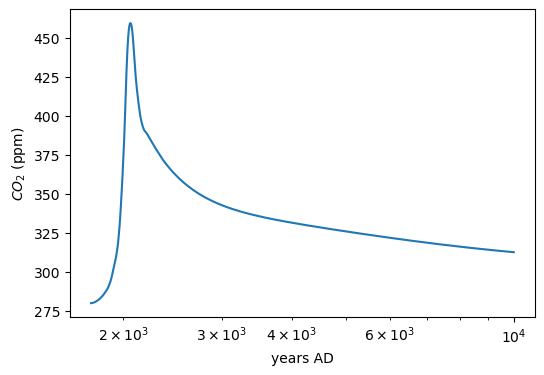

In [45]:
teval = np.logspace(log10(1750),4,1000)
model_params = params_setup()
sol =  SURFER(emissions_ssp(0),y0,teval,model_params,IS_params,interp_sol=False,ktemp = True, sediments=True,weathering = True)

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.semilogx(sol.t,PgCtoppm(sol.y[0]))
ax.set_xlabel('years AD')
ax.set_ylabel('$CO_2$ (ppm)')

Now that the code is precompiled the model should be quite fast. Here we measure its speed for a 10000 yr run forced with SS1-2.6 emissions. Longer simulations shouldn't take much longer as the numerical method used in the solver uses an adaptative time step, with bigger steps when the model is closer to equilibrium. 

In [46]:
%%timeit

sol =  SURFER(emissions_ssp(0),y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)


50.9 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Comparaison with GLODAP data

We compare the state of the ocean in the year 2002 modeled by SURFER v3.0 for an hsitorical run with vertical profiles computed from the GLODAPv2.2016b mapped climatologies from [Lauvset et al. (2016)](https://essd.copernicus.org/articles/8/325/2016/).


In [47]:
t0=1750; tend=2020;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
model_params = params_setup()

sol =  SURFER(emissions_ssp(0),y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)


16.337837388516334
8.946147143258543
2.647635732166407


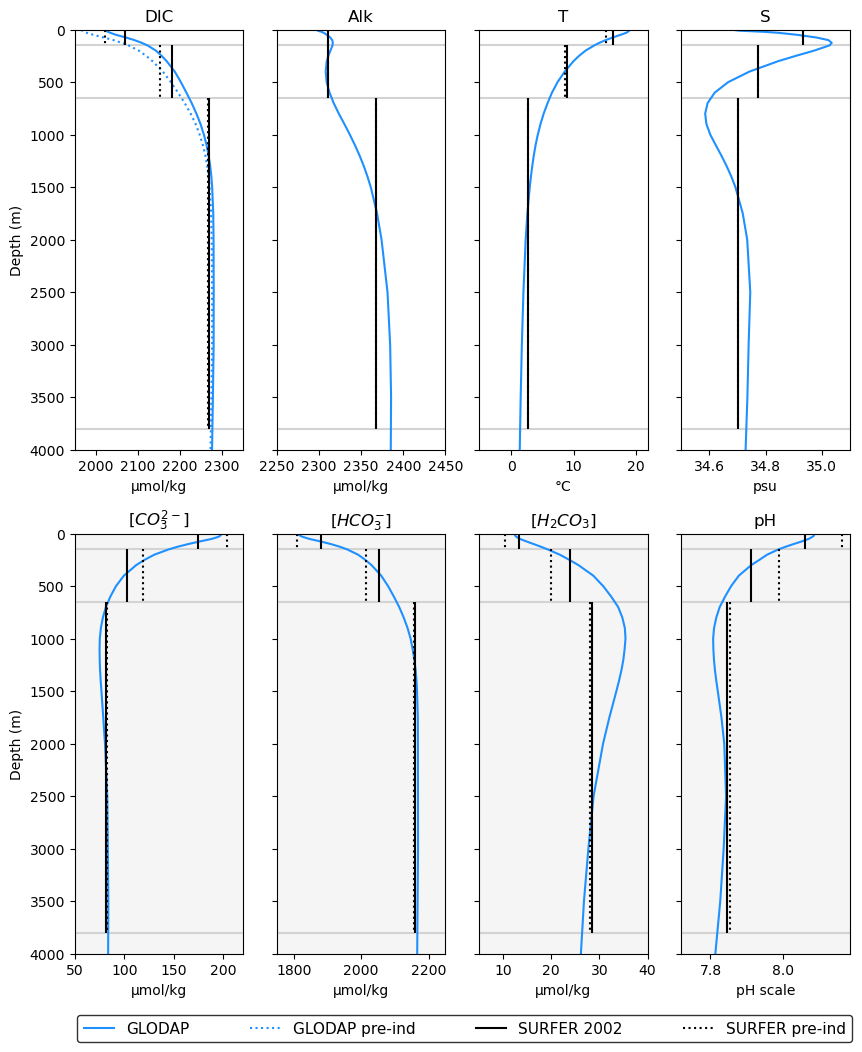

In [48]:
## Initial oceanic properties (1750)

H_U, CO3_U, HCO3_U, H2CO3_U, OH_U, BOH4_U = species_from_DICALK_masses(MU_pi,QU_pi,T_U,S_U, level = 'U')
H_I, CO3_I, HCO3_I, H2CO3_I, OH_I, BOH4_I = species_from_DICALK_masses(MI_pi,QI_pi,T_I,S_I, level = 'I')
H_D, CO3_D, HCO3_D, H2CO3_D, OH_D, BOH4_D = species_from_DICALK_masses(MD_pi,QD_pi,T_D,S_D, level = 'D')

ph_U = -np.log10(H_U)
ph_I = -np.log10(H_I)
ph_D = -np.log10(H_D)

## Oceanic properties in year 2002


solDIC_U = sol.y[2,252]/(WU*carbon_molar_mass*10**-18)
solDIC_I = sol.y[3,252]/(WI*carbon_molar_mass*10**-18)
solDIC_D = sol.y[4,252]/(WD*carbon_molar_mass*10**-18)

solQ_U = sol.y[5,252]/(WU*carbon_molar_mass*10**-18)
solQ_I = sol.y[6,252]/(WI*carbon_molar_mass*10**-18)
solQ_D = sol.y[7,252]/(WD*carbon_molar_mass*10**-18)

solT_U = sol.y[9,252] + T_U
solT_I = sol.y[10,252] + T_I
solT_D = sol.y[11,252] + T_D

solH_U, solCO3_U, solHCO3_U, solH2CO3_U, solOH_U, solBOH4_U = species_from_DICALK_masses(sol.y[2,252],sol.y[5,252],solT_U,S_U, level = 'U')
solH_I, solCO3_I, solHCO3_I, solH2CO3_I, solOH_I, solBOH4_I = species_from_DICALK_masses(sol.y[3,252],sol.y[6,252],solT_I,S_I, level = 'I')
solH_D, solCO3_D, solHCO3_D, solH2CO3_D, solOH_D, solBOH4_D = species_from_DICALK_masses(sol.y[4,252],sol.y[7,252],solT_D,S_D, level = 'D')

solph_U = -np.log10(solH_U)
solph_I = -np.log10(solH_I)
solph_D = -np.log10(solH_D)

## Figure 

fig,[[ax1,ax2,ax3,ax4],[ax6,ax7,ax8,ax5]] =plt.subplots(2,4,figsize=(10,12),sharey = True)

ax1.set_ylim((4000,0))

for axes in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] :
    axes.axhline(0,0,1,c='lightgray')
    axes.axhline(hu,0,1,c='lightgray')
    axes.axhline(hu+hi,0,1,c='lightgray')
    axes.axhline(hu+hi+hd,0,1,c='lightgray')
    
## Plot weighted averaged depth profiles

GLODAP_data = np.loadtxt(os.path.join(base_path, 'SURFER_v3/data/GLODAP_averaged_data.csv'), delimiter=",")
GLODAP_computed_data = np.loadtxt(os.path.join(base_path, 'SURFER_v3/data/GLODAP_computed_data.csv'), delimiter=",")
DEPTH = GLODAP_data[0]

kwargs3={'linestyle':'-', 'color':'dodgerblue'}


ax1.plot(GLODAP_data[2], DEPTH,**kwargs3)
ax1.plot(GLODAP_data[1], DEPTH,color='dodgerblue',ls=':')
ax2.plot(GLODAP_data[3], DEPTH,**kwargs3)
ax3.plot(GLODAP_data[4], DEPTH,**kwargs3)
ax4.plot(GLODAP_data[5], DEPTH,**kwargs3)
ax5.plot(GLODAP_data[6], DEPTH,**kwargs3)
ax6.plot(GLODAP_computed_data[2], DEPTH,**kwargs3)
ax7.plot(GLODAP_computed_data[3], DEPTH,**kwargs3)
ax8.plot(GLODAP_computed_data[4], DEPTH,**kwargs3)

## Plot initial conditions

kwargs={'linestyle':':', 'color':'k'}

ax1.vlines(DIC_U,0,hu,**kwargs)
ax1.vlines(DIC_I,hu,hu+hi,**kwargs)
ax1.vlines(DIC_D,hu+hi,hu+hi+hd,**kwargs)

ax2.vlines(alk_U,0,hu,**kwargs)
ax2.vlines(alk_I,hu,hu+hi,**kwargs)
ax2.vlines(alk_D,hu+hi,hu+hi+hd,**kwargs)

ax3.vlines(T_U-273.15,0,hu,**kwargs)
ax3.vlines(T_I-273.15,hu,hu+hi,**kwargs)
ax3.vlines(T_D-273.15,hu+hi,hu+hi+hd,**kwargs)

ax4.vlines(S_U,0,hu,**kwargs)
ax4.vlines(S_I,hu,hu+hi,**kwargs)
ax4.vlines(S_D,hu+hi,hu+hi+hd,**kwargs)

ax5.vlines(ph_U,0,hu,**kwargs)
ax5.vlines(ph_I,hu,hu+hi,**kwargs)
ax5.vlines(ph_D,hu+hi,hu+hi+hd,**kwargs)

ax6.vlines(CO3_U,0,hu,**kwargs)
ax6.vlines(CO3_I,hu,hu+hi,**kwargs)
ax6.vlines(CO3_D,hu+hi,hu+hi+hd,**kwargs)

ax7.vlines(HCO3_U,0,hu,**kwargs)
ax7.vlines(HCO3_I,hu,hu+hi,**kwargs)
ax7.vlines(HCO3_D,hu+hi,hu+hi+hd,**kwargs)

ax8.vlines(H2CO3_U,0,hu,**kwargs)
ax8.vlines(H2CO3_I,hu,hu+hi,**kwargs)
ax8.vlines(H2CO3_D,hu+hi,hu+hi+hd,**kwargs)

## Plot solution in 2002

kwargs2={'linestyle':'-', 'color':'k'}

ax1.vlines(solDIC_U,0,hu,**kwargs2)
ax1.vlines(solDIC_I,hu,hu+hi,**kwargs2)
ax1.vlines(solDIC_D,hu+hi,hu+hi+hd,**kwargs2)

ax2.vlines(solQ_U,0,hu,**kwargs2)
ax2.vlines(solQ_I,hu,hu+hi,**kwargs2)
ax2.vlines(solQ_D,hu+hi,hu+hi+hd,**kwargs2)

ax3.vlines(solT_U-273.15,0,hu,**kwargs2)
ax3.vlines(solT_I-273.15,hu,hu+hi,**kwargs2)
ax3.vlines(solT_D-273.15,hu+hi,hu+hi+hd,**kwargs2)

ax4.vlines(S_U,0,hu,**kwargs2)
ax4.vlines(S_I,hu,hu+hi,**kwargs2)
ax4.vlines(S_D,hu+hi,hu+hi+hd,**kwargs2)

ax5.vlines(solph_U,0,hu,**kwargs2)
ax5.vlines(solph_I,hu,hu+hi,**kwargs2)
ax5.vlines(solph_D,hu+hi,hu+hi+hd,**kwargs2)

ax6.vlines(solCO3_U,0,hu,**kwargs2)
ax6.vlines(solCO3_I,hu,hu+hi,**kwargs2)
ax6.vlines(solCO3_D,hu+hi,hu+hi+hd,**kwargs2)

ax7.vlines(solHCO3_U,0,hu,**kwargs2)
ax7.vlines(solHCO3_I,hu,hu+hi,**kwargs2)
ax7.vlines(solHCO3_D,hu+hi,hu+hi+hd,**kwargs2)

ax8.vlines(solH2CO3_U,0,hu,**kwargs2)
ax8.vlines(solH2CO3_I,hu,hu+hi,**kwargs2)
ax8.vlines(solH2CO3_D,hu+hi,hu+hi+hd,**kwargs2)


## Plot characteristics

ax1.set_title('DIC')
ax2.set_title('Alk')
ax3.set_title('T')
ax4.set_title('S')
ax5.set_title('pH')
ax6.set_title(r'$[CO_3^{2-}]$')
ax7.set_title(r'$[HCO_3^{-}]$')
ax8.set_title(r'$[H_2CO_3]$')

ax1.set_xlim((1950,2350))
ax2.set_xlim((2250,2450))
ax3.set_xlim((268-273.15,295-273.15))
ax4.set_xlim((34.5,35.1))
# ax5.set_xlim((7.7,8.25))
ax6.set_xlim((50,220))
ax7.set_xlim((1750,2250))
ax8.set_xlim((5,40))

ax1.set_xlabel('µmol/kg')
ax2.set_xlabel('µmol/kg')
ax3.set_xlabel('°C')
ax4.set_xlabel('psu')
ax5.set_xlabel('pH scale')
ax6.set_xlabel('µmol/kg')
ax7.set_xlabel('µmol/kg')
ax8.set_xlabel('µmol/kg')

ax1.set_ylabel('Depth (m)')
ax6.set_ylabel('Depth (m)')

ax5.set_facecolor('whitesmoke')
ax6.set_facecolor('whitesmoke')
ax7.set_facecolor('whitesmoke')
ax8.set_facecolor('whitesmoke')

#Legend

ax1.plot([],[],c='dodgerblue',ls='-',label='GLODAP')
ax1.plot([],[],c='dodgerblue',ls=':',label='GLODAP pre-ind')
ax1.plot([],[],c='k',ls='-',label='SURFER 2002')
ax1.plot([],[],c='k',ls=':',label='SURFER pre-ind')
fig.legend(loc = 'lower left', bbox_to_anchor = (0.12,0.03,0.79,0.01), mode = 'expand', ncols = 4,facecolor = 'none', edgecolor='k',fontsize=11,handlelength = 2)

# Uncomment next line to save figure in the defined repository (see Setup)
#fig.savefig(os.path.join(figures_path, 'fig03.pdf'),bbox_inches='tight')

print(solT_U-273.15)
print(solT_I-273.15)
print(solT_D-273.15)

## Historical period

In [49]:
SURFERv2_cmip6_ssp126 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURFERv2_cmip6_ssp126.csv'), delimiter=",")
SURFERv2_cmip6_ssp370 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURFERv2_cmip6_ssp370.csv'), delimiter=",")

In [50]:
t0=1750; tend=2100;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

model_params = params_setup()
F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl = model_params
sol =  SURFER(emissions_ssp(0),y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

tempU = T_U + sol.y[9]
K0 = k0(tempU,S_U)
B = vBU(sol.y[2],sol.y[5],tempU,S_U)

F_AU = K_AU*(sol.y[0]*K0-mA/(WU)*B*sol.y[2])
F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/sol.y[0])-(sol.y[1]-sol.y[13]))

F_CaCO3 = F_CaCO3_pi*(1+K_Ca*sol.y[9])
F_CaSiO3 = F_CaSiO3_pi*np.exp(K_T*sol.y[9])
F_weathering = 2*F_CaSiO3 + F_CaCO3

bim_weathering = F_weathering-F_weathering[0]
bim_ch4 = (sol.y[12]-Mch4_pi)/tau_ch4

F_AU_net = F_AU + F_weathering
F_AU_net = F_AU 
atm_uptake = F_CaSiO3_pi + CO2_fossil_ssp[0](sol.t)+ CO2_landuse_ssp[0](sol.t) - F_AU - F_AL - F_weathering + (sol.y[12]-Mch4_pi)/tau_ch4
ocean_sink = F_AU_net - F_AU_net[0]
land_sink = F_AL 


max difference is  6.073439969765332  ppm


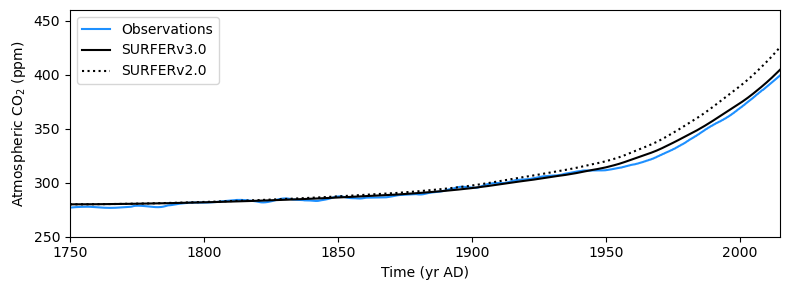

In [51]:
CO2_Kohler = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/CO2_Kohler.csv'), delimiter=',')

fig, ax = plt.subplots(1,1,figsize=(8,3)) 

ax.plot(CO2_Kohler[0],CO2_Kohler[1],color='dodgerblue',label = 'Observations')
ax.plot(sol.t,PgCtoppm(sol.y[0]),color = 'k',label = 'SURFERv3.0')
ax.plot(SURFERv2_cmip6_ssp126[0],SURFERv2_cmip6_ssp126[1],color = 'k',ls=':',label = 'SURFERv2.0')

ax.set_xlim((1750,2016))
ax.set_xlabel('Time (yr AD)')
ax.set_ylabel(r'Atmospheric CO$_2$ (ppm)')
ax.set_ylim((250,460))
ax.legend()

ax.set_xlim((1750,2015))
plt.tight_layout()

# compute max difference

co2_obs = interpolate.interp1d(CO2_Kohler[0],CO2_Kohler[1],bounds_error= True)
co2_diff = np.abs(PgCtoppm(sol.y[0,:265])-co2_obs(sol.t[:265]))
print('max difference is ',np.max(co2_diff),' ppm')

# Uncomment next line to save figure in the defined repository (see Setup)
#fig.savefig(os.path.join(figures_path, 'fig04.pdf'),bbox_inches='tight')

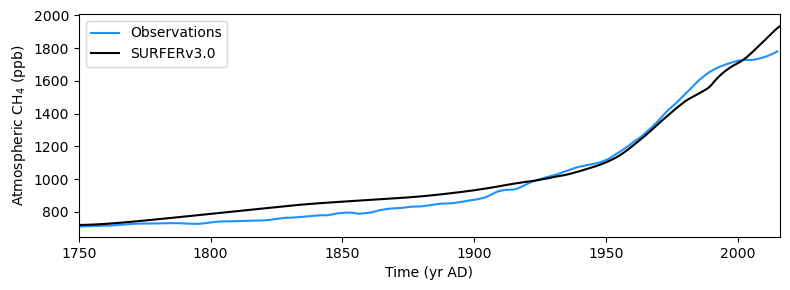

In [52]:
CH4_Kohler = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/CH4_Kohler.csv'), delimiter=',')

fig, ax = plt.subplots(1,1,figsize=(8,3)) 


ax.plot(CH4_Kohler[0],CH4_Kohler[1],color='dodgerblue',label = 'Observations')
ax.plot(sol.t,PgCtoppb(sol.y[12]),color = 'k',label = 'SURFERv3.0')

ax.set_xlim((1750,2016))
ax.set_xlabel('Time (yr AD)')
ax.set_ylabel(r'Atmospheric CH$_4$ (ppb)')
ax.legend()

plt.tight_layout()

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig05.pdf'),bbox_inches='tight')

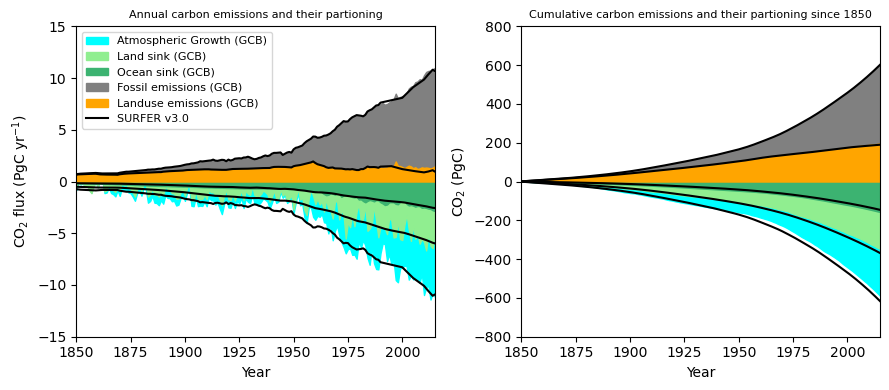

In [53]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(9,4))

# Global carbon  project

ax.fill_between(GCB[:,0],(-GCB[:,4]-GCB[:,5])*0,-GCB[:,4]-GCB[:,5]-GCB[:,3],color='cyan',label='Atmospheric Growth (GCB)')
ax.fill_between(GCB[:,0],-GCB[:,4]*0,-GCB[:,4]-GCB[:,5],color='lightgreen',label='Land sink (GCB)')
ax.fill_between(GCB[:,0],GCB[:,4]*0,-GCB[:,4],color='mediumseagreen',label='Ocean sink (GCB)')

ax.fill_between(GCB[:,0],GCB[:,2],GCB[:,2]+GCB[:,1]-GCB[:,6],color='gray',label ='Fossil emissions (GCB)')
ax.fill_between(GCB[:,0],GCB[:,2]*0,GCB[:,2],color='orange', label ='Landuse emissions (GCB)')

ax2.fill_between(GCB[100:,0],np.cumsum((-GCB[100:,4]-GCB[100:,5])*0),np.cumsum(-GCB[100:,4]-GCB[100:,5]-GCB[100:,3]),color='cyan',label='Atmospheric Growth')
ax2.fill_between(GCB[100:,0],np.cumsum(-GCB[100:,4]*0),np.cumsum(-GCB[100:,4]-GCB[100:,5]),color='lightgreen',label='Land sink')
ax2.fill_between(GCB[100:,0],np.cumsum(GCB[100:,4]*0),np.cumsum(-GCB[100:,4]),color='mediumseagreen',label='Ocean sink')

ax2.fill_between(GCB[100:,0],np.cumsum(GCB[100:,2]),np.cumsum(GCB[100:,2]+GCB[100:,1]-GCB[100:,6]),color='gray',label ='Fossil emissions')
ax2.fill_between(GCB[100:,0],np.cumsum(GCB[100:,2]*0),np.cumsum(GCB[100:,2]),color='orange', label ='Landuse emissions')


# Surfer

ax.plot(sol.t,-(atm_uptake+land_sink+ocean_sink),color = 'k')  
ax.plot(sol.t,-(ocean_sink),color = 'k')
ax.plot(sol.t,-(ocean_sink+land_sink),color = 'k')

ax.plot(sol.t,CO2_fossil_ssp[0](sol.t)+CO2_landuse_ssp[0](sol.t),'k',label='SURFER v3.0')
ax.plot(sol.t,CO2_landuse_ssp[0](sol.t),'k')

ax2.plot(sol.t[100:],np.cumsum(-atm_uptake[100:]-ocean_sink[100:]-land_sink[100:]),color = 'k') 
ax2.plot(sol.t[100:],np.cumsum(-ocean_sink[100:]),color = 'k')
ax2.plot(sol.t[100:],np.cumsum(-land_sink[100:]-ocean_sink[100:]),color = 'k')      

ax2.plot(sol.t[100:],np.cumsum(CO2_fossil_ssp[0](sol.t[100:])+CO2_landuse_ssp[0](sol.t[100:])),'k')
ax2.plot(sol.t[100:],np.cumsum(CO2_landuse_ssp[0](sol.t[100:])),'k')

#ax.plot(sol.t,CO2_fossil_ssp[0](sol.t)+CO2_landuse_ssp[0](sol.t)+CH4_fossil_ssp[0](sol.t),'r')
#ax2.plot(sol.t[100:],np.cumsum(CO2_fossil_ssp[0](sol.t[100:])+CH4_fossil_ssp[0](sol.t[100:])+CO2_landuse_ssp[0](sol.t[100:])),'r')

# figure properties

ax.legend(fontsize=8)

ax.set_xlim((1850,2015))
ax.set_ylim((-15,15))
ax2.set_xlim((1850,2015))
ax2.set_ylim((-800,800))

ax.set_xlabel('Year')
ax2.set_xlabel('Year')
ax.set_ylabel(r'CO$_2$ flux ($\mathrm{PgC~yr^{-1}}$)')
ax2.set_ylabel('CO$_2$ (PgC)')

ax.set_title('Annual carbon emissions and their partioning',fontsize=8)
ax2.set_title('Cumulative carbon emissions and their partioning since 1850',fontsize=8)

plt.tight_layout()

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig06.pdf'),bbox_inches='tight')

In [54]:
print('Atmospheric growth and sinks mean for the years 2000-2009 (included)')
print('PgC/yr')
print('ocean sink - SURFER: ',np.mean(ocean_sink[250:260]), 'GCB: ',np.mean(GCB[250:260,4]))
print('land sink  - SURFER: ',np.mean(land_sink[250:260]),'GCB: ',np.mean(GCB[250:260,5]))
print('atm growth - SURFER: ',np.mean(atm_uptake[250:260]),' GCB: ',np.mean(GCB[250:260,3]))
print('----------------')

total_emissions = np.sum(CO2_fossil_ssp[0](sol.t[100:265])) + np.sum(CO2_landuse_ssp[0](sol.t[100:265]))
total_atm_growth = np.sum(atm_uptake[100:265])
total_ocean_sink = np.sum(ocean_sink[100:265])
total_land_sink = np.sum(land_sink[100:265])

total_bim_weathering = np.sum(bim_weathering[100:265])
total_bim_ch4 = np.sum(bim_ch4[100:265])

print('Cumulative atmospheric growth and sinks mean for the years 1850-2014 (included)')
print('PgC')
print('ocean sink - SURFER: ',np.sum(ocean_sink[100:265]), 'GCB: ',np.sum(GCB[100:265,4]))
print('land sink  - SURFER: ',np.sum(land_sink[100:265]),'GCB: ',np.sum(GCB[100:265,5]))
print('atm growth - SURFER: ',np.sum(atm_uptake[100:265]),' GCB: ',np.sum(GCB[100:265,3]))
print('budget imbalance: ', total_emissions-total_atm_growth-total_ocean_sink-total_land_sink)
print('  - contribution from weathering: ', total_bim_weathering)
print('  - contribution from methane: ', -total_bim_ch4)
print('budget including weathering and methane:',  total_emissions-total_atm_growth-total_ocean_sink-total_land_sink-total_bim_weathering+total_bim_ch4)
print(np.sum(CH4_fossil_ssp[0](sol.t[100:265])))
print(np.sum(CH4_landuse_ssp[0](sol.t[100:265])))
print('----------------')
print('Percentages of uptake')
print('Total emissions: ',total_emissions)
print('ocean sink: ',total_ocean_sink/total_emissions*100)
print('land sink: ',total_land_sink/total_emissions*100)
print('atm growth: ',total_atm_growth/total_emissions*100)

Atmospheric growth and sinks mean for the years 2000-2009 (included)
PgC/yr
ocean sink - SURFER:  2.159834890303871 GCB:  2.252
land sink  - SURFER:  3.046254134639997 GCB:  2.722
atm growth - SURFER:  3.956859050696012  GCB:  4.042
----------------
Cumulative atmospheric growth and sinks mean for the years 1850-2014 (included)
PgC
ocean sink - SURFER:  143.14103457669574 GCB:  154.38000000000002
land sink  - SURFER:  219.31728509266486 GCB:  187.13
atm growth - SURFER:  242.9821151740313  GCB:  235.81999999999996
budget imbalance:  -14.584216525210024
  - contribution from weathering:  1.2337406130471413
  - contribution from methane:  -15.817957138480098
budget including weathering and methane: 2.2293278334473143e-10
8.909464543852286
9.09331830272495
----------------
Percentages of uptake
Total emissions:  590.8562183181818
ocean sink:  24.22603505538684
land sink:  37.11855410728035
atm growth:  41.123729875545294


We can further look at the budget imbalance (not in the paper)

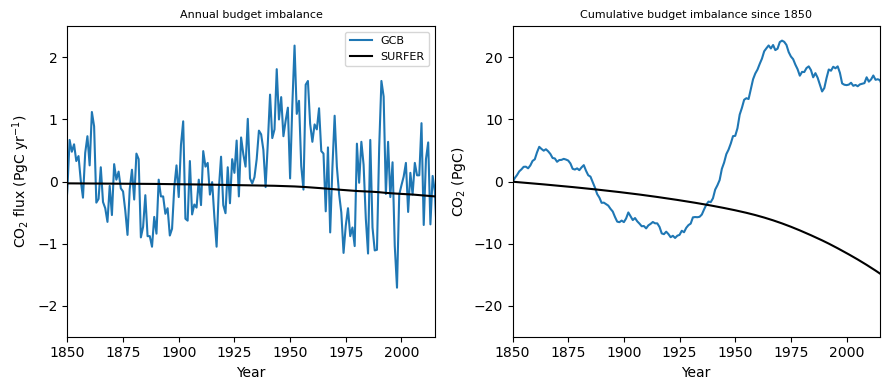

In [55]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(9,4))

# Global carbon  project

bim_GCP = GCB[:,2]+GCB[:,1]-GCB[:,6]-GCB[:,4]-GCB[:,5]-GCB[:,3]
ax.plot(GCB[:,0], bim_GCP,label='GCB')
ax2.plot(GCB[100:,0], np.cumsum(bim_GCP[100:]))

# Surfer (not including methane in the budget)

bim_SURFER = CO2_fossil_ssp[0](sol.t)+CO2_landuse_ssp[0](sol.t)-(atm_uptake+land_sink+ocean_sink)
ax.plot(sol.t,bim_SURFER,'k',label='SURFER')
ax2.plot(sol.t[100:],np.cumsum(bim_SURFER[100:]),'k')

# figure properties

ax.legend(fontsize=8)

ax.set_xlim((1850,2015))
ax.set_ylim((-2.5,2.5))
ax2.set_xlim((1850,2015))
ax2.set_ylim((-25,25))

ax.set_xlabel('Year')
ax2.set_xlabel('Year')
ax.set_ylabel(r'CO$_2$ flux ($\mathrm{PgC~yr^{-1}}$)')
ax2.set_ylabel('CO$_2$ (PgC)')

ax.set_title('Annual budget imbalance',fontsize=8)
ax2.set_title('Cumulative budget imbalance since 1850',fontsize=8)

plt.tight_layout()


We also compare the (cumulative) ocean and land sinks separately to other models (figure not in paper). In order to do this we need to upload some data. This data will also be used for figures of the CMIP section.

In [ ]:
#ds = xr.open_dataset("C:/Users/AL000111/Documents/Mémoire/Code_SURFERv3.0_preprint/SURFER_v3/data/nbp_traj", engine="netcdf4")
#ds = xr.open_dataset("C:\\Users\\AL000111\\Documents\\Mémoire\\Code_SURFERv3.0_preprint\\SURFER_v3\\data\\fgco2_traj", engine="netcdf4")
nbp_trajectories_2exp = xr.load_dataarray(os.path.join(base_path, '\\SURFER_v3\\data\\nbp_traj'))
fgco2_trajectories_2exp = xr.load_dataarray(os.path.join(base_path, '\\SURFER_v3\\data\\fgco2_traj'))


exps_list = ['historical','ssp585','ssp534-over','ssp126']
vars_list = ['fgco2','nbp']
models_list = ['CanESM5','CESM2-WACCM', 'IPSL-CM6A-LR', 'UKESM1', 'UVic-ESCM']

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)

startyear_exps = [1850, 2015, 2040, 2015]
endyear_exps = [2014, 2299, 2299, 2299]
nyears_total = 2299-1850+1
years = np.arange(nyears_total)+startyear_exps[0]

ssp534os_color = '#ba91cc'
ssp585_color = '#a40000'
ssp126_color = '#1f3e7d'


dashlist = ['solid',(0, (10, 2)),'dotted','dashdot','--']#, (1, (7, 2,1,2,1,2))]

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'pydap', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [59]:
CMIP6_hist = np.genfromtxt(os.path.join(base_path,'SURFER_v3/data/cmip6_hist_data.csv'), delimiter=',')
CMIP6_ssp126 = np.genfromtxt(os.path.join(base_path,'SURFER_v3/data/cmip6_ssp126_data.csv'), delimiter=',')
CMIP6_ssp370 = np.genfromtxt(os.path.join(base_path,'SURFER_v3/data/cmip6_ssp370_data.csv'), delimiter=',')
CMIP6_data = [CMIP6_hist,CMIP6_ssp126,CMIP6_ssp370]

The ocean sink plotted is the same as the one defined above. For the land sink, we plot a slightly different quantity : the previously defined land sink ($F_{A\rightarrow L}$) minus the landuse emissions of $CO_2$ and $CH_4$. This is is the Net Biome Productivity (NBP) which is defined by the IBPES as :

> NBP is the Net Ecosystem Productivity (NEP) corrected for lateral transfers of carbon to adjacent biomes, due to process such as trade in agricultural products, export of organic matter in rivers and losses due to disturbances, including land clearing and wildfire.

(Note : The NEP is the difference between Gross Primary Production (GPP) and net ecosystem respiration, which is the respiration of carbon by plants AND by other animals and microbes (so includes respiration in soil). In SURFER, $F_{A\rightarrow L}$ corresponds to the NEP)

NameError: name 'nmodels' is not defined

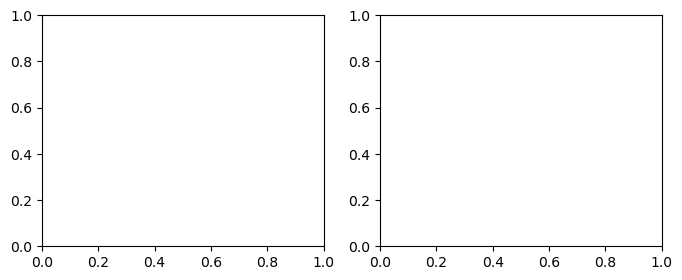

In [60]:
fig, [ax2,ax1] = plt.subplots(1,2,figsize=(8,3),sharex=True)

# Plot data from CMIP§ models (and UVic-ESCM)

linelist = []
for model_i in range(nmodels):
    a3, = ax1.plot(years, np.cumsum(nbp_trajectories_2exp[model_i,2,:]), color=ssp126_color, linestyle=dashlist[model_i],alpha=0.5)
    
    ax2.plot(years, np.cumsum(fgco2_trajectories_2exp[model_i,2,:]), color=ssp126_color, linestyle=dashlist[model_i],alpha=0.5)
    a4, = ax2.plot([],[], color='gray', linestyle=dashlist[model_i],label = models_list[model_i],alpha=0.5)
    linelist.append(a4)

axes_list = fig.get_axes()

# Plot data from the Global carbon budget (Friedliegstein et al., 2022)

gcp1, = ax2.plot(GCB[100:,0],np.cumsum(GCB[100:,4]),color='mediumseagreen',label='GCB')
ax1.plot(GCB[100:,0],np.cumsum(GCB[100:,5])-np.cumsum(GCB[100:,2]),color='lightgreen',label='GCB')
linelist.append(gcp1)

cmip,=ax2.plot(CMIP6_data[0][:,18],np.cumsum(CMIP6_data[0][:,19]),'r-',label = 'CMIP6 mean')
ax1.plot(CMIP6_data[0][:,24],np.cumsum(CMIP6_data[0][:,25]),'r')
linelist.append(cmip)

# Plot results from SURFER
 
ax2.plot(sol.t[100:],np.cumsum(ocean_sink[100:]),c='k')
ax1.plot(sol.t[100:],np.cumsum(land_sink[100:]-CO2_landuse_ssp[0](sol.t[100:])-CH4_landuse_ssp[0](sol.t[100:])),c='k')

# figure properties
    
ax1.set_xlim((1850,2014))
ax2.set_ylim((-10,200))
ax1.set_ylim((-100,50))

ax1.set_title('Net cumulative land sink')
ax2.set_title('Net cumulative ocean sink')

ax2.set_ylabel('PgC')

ax1.set_xlabel('Time (yrs AD)')
ax2.set_xlabel('Time (yrs AD)')

m2, = ax1.plot([],[],'k',ls='-',label ='SURFER')
linelist.append(m2)

ax2.legend(handles= linelist,loc = 'upper left',fontsize=8,labelspacing=0.2,ncol = 1, handlelength = 3.5,alignment ='right',edgecolor='none', facecolor='none',title_fontproperties = {'weight':'bold'},columnspacing=1.7)

plt.tight_layout()

## CMIP6

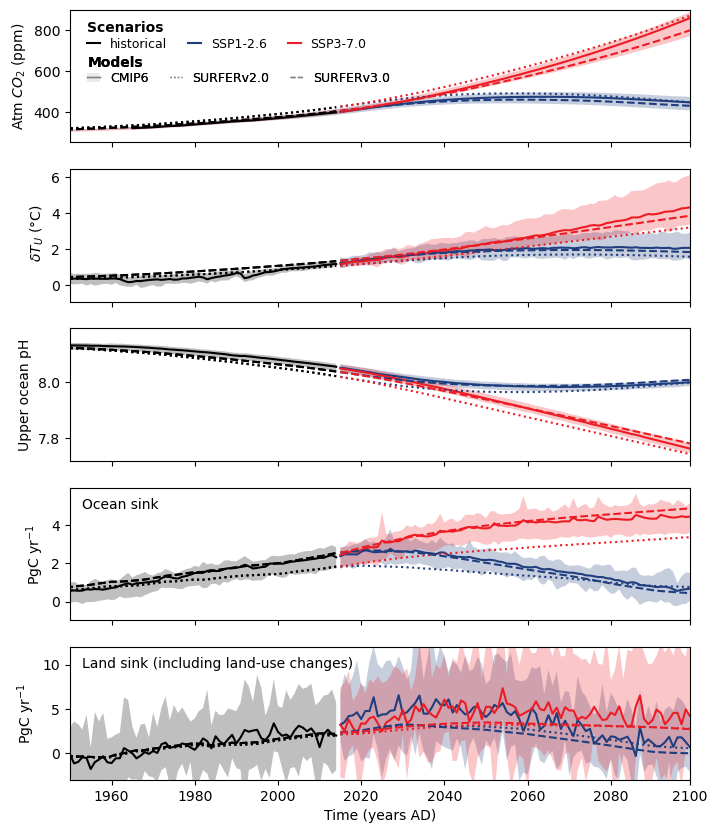

In [61]:
fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(5,1,figsize=(8,10),sharex= True) 

# Plot CMIP6 data fo historical runs and SSP1-2.6 and SSP3-7.0 scenarios

axes = [ax1,ax2,ax3,ax4,ax5]
colors = ['k','#1f3e7d','#ed1c24']
for j in range(0,3) : 
    
    for i in range(0,5):

        axes[i].plot(CMIP6_data[j][:,6*i],CMIP6_data[j][:,6*i+1], color = colors[j])
        axes[i].fill_between(CMIP6_data[j][:,6*i+2],CMIP6_data[j][:,6*i+3],CMIP6_data[j][:,6*i+5],color = colors[j], alpha = 0.25,edgecolor='none')

ssp_indexes = [0,3]
ssp_colors = ['#1f3e7d','#ed1c24']


# Plot output from SURFERv2.0

SURFERv2_cmip6 = [SURFERv2_cmip6_ssp126,SURFERv2_cmip6_ssp370]
LS = ':'

for i in range(0,2) : 
    for j in range(0,5):
        axes[j].plot(SURFERv2_cmip6[i][0,:265],SURFERv2_cmip6[i][j+1,:265],color = 'k',ls= LS)
        axes[j].plot(SURFERv2_cmip6[i][0,265:],SURFERv2_cmip6[i][j+1,265:],color = ssp_colors[i],ls= LS)

# Plot output from SURFERv3.0

t0=1750; tend=2100;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
model_params = params_setup()

LS = '--'

for i in range(0,2) : 
    
    sol =  SURFER(emissions_ssp(ssp_indexes[i]),y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

    tempU = T_U + sol.y[9]
    K0 = k0(tempU,S_U)
    B = vBU(sol.y[2],sol.y[5],tempU,S_U)
    H = vh_from_DICALK_masses(sol.y[2],sol.y[5],tempU,S_U,level = 'U') 
    
    F_AU = K_AU*(sol.y[0]*K0-mA/(WU)*B*sol.y[2])
    F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/sol.y[0])-(sol.y[1]-sol.y[13]))
    
    F_CaCO3 = F_CaCO3_pi*(1+K_Ca*sol.y[9])
    F_CaSiO3 = F_CaSiO3_pi*np.exp(K_T*sol.y[9])
    F_weathering = 2*F_CaSiO3 + F_CaCO3
    
    F_AU_net = F_AU + F_weathering
    F_AU_net = F_AU 
    ocean_sink = F_AU_net - F_AU_net[0]
    land_sink = F_AL 
    nbp = land_sink -CO2_landuse_ssp[ssp_indexes[i]](sol.t)-CH4_landuse_ssp[ssp_indexes[i]](sol.t)

    ax1.plot(sol.t[:265],PgCtoppm(sol.y[0,:265]),color = 'k',ls= LS)
    ax2.plot(sol.t[:265],sol.y[9,:265],color = 'k',ls= LS)
    ax3.plot(sol.t[:265],-np.log10(H[:265]),color = 'k',ls= LS)
    ax4.plot(sol.t[:265],ocean_sink[:265],color = 'k',ls= LS)
    ax5.plot(sol.t[:265],nbp[:265],color = 'k',ls= LS)
   
    ax1.plot(sol.t[265:],PgCtoppm(sol.y[0][265:]),color = ssp_colors[i],ls= LS)
    ax2.plot(sol.t[265:],sol.y[9][265:],color = ssp_colors[i],ls= LS)
    ax3.plot(sol.t[265:],-np.log10(H[265:]),color = ssp_colors[i],ls= LS)
    ax4.plot(sol.t[265:],ocean_sink[265:],color = ssp_colors[i],ls= LS)
    ax5.plot(sol.t[265:],nbp[265:],color = ssp_colors[i],ls= LS)

# Plot GCB
#ax4.plot(GCB[:,0],GCB[:,4],color='mediumseagreen',label='Ocean sink (GCP)')
#ax5.plot(GCB[:,0],GCB[:,5],color='mediumseagreen',label='Land sink (GCP)')

# Figure properties 

ax1.set_xlim(1950,2099)
ax1.set_ylim((250,900))

ax5.set_ylim((-3,12))

ax1.set_ylabel(r'Atm $CO_2$ (ppm)')
ax2.set_ylabel(r' $\delta T_U$ (°C)')
ax3.set_ylabel(r'Upper ocean pH')
ax4.set_ylabel(r'$\mathrm{PgC~yr^{-1}}$')
ax5.set_ylabel(r'$\mathrm{PgC~yr^{-1}}$')

ax4.annotate(r'Ocean sink',(0.02,0.84),xycoords='axes fraction')
ax5.annotate(r'Land sink (including land-use changes)',(0.02,0.84),xycoords='axes fraction')

ax5.set_xticks([1960,1980,2000,2020,2040,2060,2080,2099])
ax5.set_xticklabels([1960,1980,2000,2020,2040,2060,2080,2100])
ax5.set_xlabel('Time (years AD)')

l1, = ax1.plot([],[],'k',label ='historical')
l2, = ax1.plot([],[],color =colors[1],label ='SSP1-2.6')
l3, = ax1.plot([],[],color =colors[2],label ='SSP3-7.0')

m12 = ax1.fill_between([np.nan],[np.nan],[np.nan],color = 'lightgray',edgecolor='none',alpha = 0.25,label ='CMIP6')
m1, = ax1.plot([],[],'gray',ls='-',lw=1,label ='CMIP6')

m2, = ax1.plot([],[],'gray',ls=':',lw=1,label ='SURFERv2.0')
m3, = ax1.plot([],[],'gray',ls='--',lw=1,label ='SURFERv3.0')
   
first_legend = ax1.legend(handles= [l1,l2,l3],loc = 'upper left',bbox_to_anchor=(0.01,0.5,.9,0.5),fontsize=9,labelspacing=0.2,ncol = 3, handlelength = 1, title = 'Scenarios',alignment ='left',edgecolor='none', facecolor='none',title_fontproperties = {'weight':'bold'},columnspacing=1.7)
second_legend = ax1.legend([(m12,m1),m2,m3],['CMIP6','SURFERv2.0','SURFERv3.0'],loc = 'lower left',bbox_to_anchor=(0.01,0.35,.9,0.65),fontsize=9,labelspacing=0.2,ncol = 3, handlelength = 1, title = 'Models',alignment ='left',edgecolor='none', facecolor ='none',title_fontproperties = {'weight':'bold'},columnspacing=1.7)

ax1.add_artist(first_legend)
ax1.add_artist(second_legend)

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig07.pdf'),bbox_inches='tight')

<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
C:\Users\AL000111\AppData\Local\Temp\ipykernel_2984\1432746653.py:63: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('$\mathrm{PgC~yr^{-1}}$')
C:\Users\AL000111\AppData\Local\Temp\ipykernel_2984\1432746653.py:64: SyntaxWarning: invalid escape sequence '\m'
  ax3.set_ylabel('$\mathrm{PgC~yr^{-1}}$')
C:\Users\AL000111\AppData\Local\Temp\ipykernel_2984\1432746653.py:65: SyntaxWarning: invalid escape sequence '\m'
  ax5.set_ylabel('$\mathrm{PgC~yr^{-1}}$')
C:\Users\AL000111\AppData\Local\Temp\ipykernel_2984\1432746653.py:63: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('$\mathrm{PgC~yr^{-1}}$')
C:\Users\AL000111\AppData\Local\Temp\ipykernel_2984\1432746653.py:

NameError: name 'nmodels' is not defined

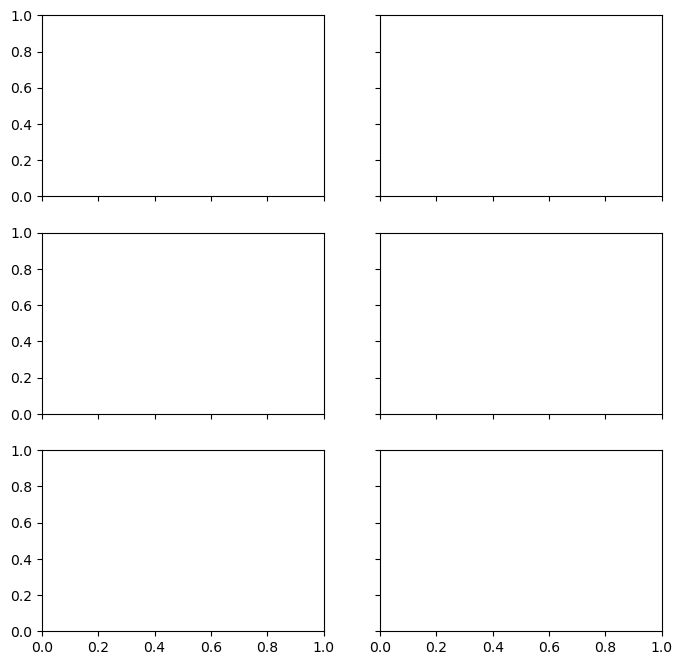

In [62]:
fig, [[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(8,8),sharex=True,sharey='row')

# Plot data CMIP6

linelist = []
for model_i in range(nmodels):
    a1, = ax5.plot(years, nbp_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i],alpha=0.5)
    a2, = ax3.plot(years, nbp_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i],alpha=0.5)
    a3, = ax1.plot(years, nbp_trajectories_2exp[model_i,2,:], color=ssp126_color, linestyle=dashlist[model_i],alpha=0.5)
    
    ax6.plot(years, fgco2_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i],alpha=0.5)
    ax4.plot(years, fgco2_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i],alpha=0.5)
    ax2.plot(years, fgco2_trajectories_2exp[model_i,2,:], color=ssp126_color, linestyle=dashlist[model_i],alpha=0.5)
    a4, = ax2.plot([],[], color='gray', linestyle=dashlist[model_i],label = models_list[model_i],alpha=0.5)
    linelist.append(a4)

    axes_list = fig.get_axes()

for axes in axes_list :
    axes.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)

# Plot data SURFERv3.0

ssp_indexes = [0,5,4]
t0=1750; tend=3000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
model_params = params_setup()

for i in range(0,3) : 
    
    sol =  SURFER(emissions_ssp(ssp_indexes[i]),y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

    tempU = T_U + sol.y[9]
    K0 = k0(tempU,S_U)
    B = vBU(sol.y[2],sol.y[5],tempU,S_U)
    H = vh_from_DICALK_masses(sol.y[2],sol.y[5],tempU,S_U,level = 'U') 
    
    F_AU = K_AU*(sol.y[0]*K0-mA/(WU)*B*sol.y[2])
    F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/sol.y[0])-(sol.y[1]-sol.y[13]))
    
    F_CaCO3 = F_CaCO3_pi*(1+K_Ca*sol.y[9])
    F_CaSiO3 = F_CaSiO3_pi*np.exp(K_T*sol.y[9])
    F_weathering = 2*F_CaSiO3 + F_CaCO3
    
    F_AU_net = F_AU + F_weathering
    F_AU_net = F_AU 
    ocean_sink = F_AU_net - F_AU_net[0]
    land_sink = F_AL 
    nbp = land_sink -CO2_landuse_ssp[ssp_indexes[i]](sol.t)-CH4_landuse_ssp[ssp_indexes[i]](sol.t)

    axes_list[i*2+1].plot(sol.t,ocean_sink,c='k')
    axes_list[i*2].plot(sol.t,nbp,c='k')

# Figure properties

ax1.annotate('SSP1-2.6',(0.05,0.9),xycoords='axes fraction',color = ssp126_color)
ax3.annotate('SSP5-3.4 over',(0.05,0.9),xycoords='axes fraction',color = ssp534os_color)
ax5.annotate('SSP5-8.5',(0.05,0.9),xycoords='axes fraction',color = ssp585_color)
ax1.set_xlim((1850,2300))
ax1.set_title('Land sink (including land-use changes)',fontsize=10)
ax2.set_title('Ocean sink',fontsize=10)

ax1.set_ylabel('$\mathrm{PgC~yr^{-1}}$')
ax3.set_ylabel('$\mathrm{PgC~yr^{-1}}$')
ax5.set_ylabel('$\mathrm{PgC~yr^{-1}}$')

ax5.set_xlabel('Time (yrs AD)')
ax6.set_xlabel('Time (yrs AD)')

m2, = ax1.plot([],[],'k',ls='-',label ='SURFER')
linelist.append(m2)

ax2.legend(handles= linelist,loc = 'upper right',fontsize=8,labelspacing=0.2,ncol = 1, handlelength = 3.5,alignment ='right',edgecolor='none', facecolor='none',title_fontproperties = {'weight':'bold'},columnspacing=1.7)

plt.tight_layout()

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig08.pdf'),bbox_inches='tight')

## LTMIP

We compare SURFER v3 to models that participated in the LTMIP experiments [(Archer et al., 2009)](https://climatemodels.uchicago.edu/geocarb/archer.2009.ann_rev_tail.pdf) . In the paper, we also added the results from the LOSCAR model [(Zeebe, 2012)](https://gmd.copernicus.org/articles/5/149/2012/gmd-5-149-2012.html) . The data from LOSCAR is accessible through personnal correspondance with Richard Zeebe,  and not included in the figures here. 

In [63]:
c1000 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_1000.csv'), delimiter=',')
c1000_c = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_1000_c.csv'), delimiter=',')
c1000_cs = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_1000_cs.csv'), delimiter=',')
c1000_csw = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_1000_csw.csv'), delimiter=',')
c1000_cswv = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_1000_cswv.csv'), delimiter=',')
c1000_burrial = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_1000_burial.csv'), delimiter=',')

c5000 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_5000.csv'), delimiter=',')
c5000_c = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_5000_c.csv'), delimiter=',')
c5000_cs = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_5000_cs.csv'), delimiter=',')
c5000_csw = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_5000_csw.csv'), delimiter=',')
c5000_cswv = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_5000_cswv.csv'), delimiter=',')
c5000_burrial = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/LTMIP_data/archer_5000_burial.csv'), delimiter=',')

CC = ['#b8e04f','gray','#c5161c','#77369e','#5ec232','#176fc1','#80d5dd','#cf2a9e','#f57215']
labels = ['GEOCYC','CC_SED','UVic2.8','CLIMBER','GENIE-8','GENIE-16','LTCM','MESMO','MPI-UW']

mass_o = mO*water_molar_mass

SURFERv2_LTMIP = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURFERv2_LTMIP.csv'), delimiter=",")

#### 1000 PgC pulse

In [64]:
t0=0 ; tend=10000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi+1000,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]

model_params = params_setup()
model_params_noveg = params_setup(K_AL=0)

# 5 experiments

sol      =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = False, sediments=False,weathering = False)
sol_c    =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = True, sediments=False,weathering = False)
sol_cs   =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = False)
sol_csw  =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)
sol_cswv =  SURFER(zero_emissions,y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

# accumulation for CS experiment 

H_D, CO3_D, HCO3_D, H2CO3_D, OH_D, BOH4_D = vspecies_from_DICALK_masses(sol_cs.y[4],sol_cs.y[7],T_D+sol_cs.y[11],S_D, level = 'D')
acc_1000 = F_CaCO3_pi+F_CaSiO3_pi - (alpha_diss*(CO3_D-CO32D_pi)+beta_diss*(sol_cs.y[8]-MS_pi)+gamma_diss*(CO3_D-CO32D_pi)*(sol_cs.y[8]-MS_pi))

# DIC and ALK for CS experiment

DIC_1000 = (sol_cs.y[2]+sol_cs.y[3]+sol_cs.y[4])*10**21/mass_o/12
ALK_1000 = (sol_cs.y[5]+sol_cs.y[6]+sol_cs.y[7])*10**21/mass_o/12

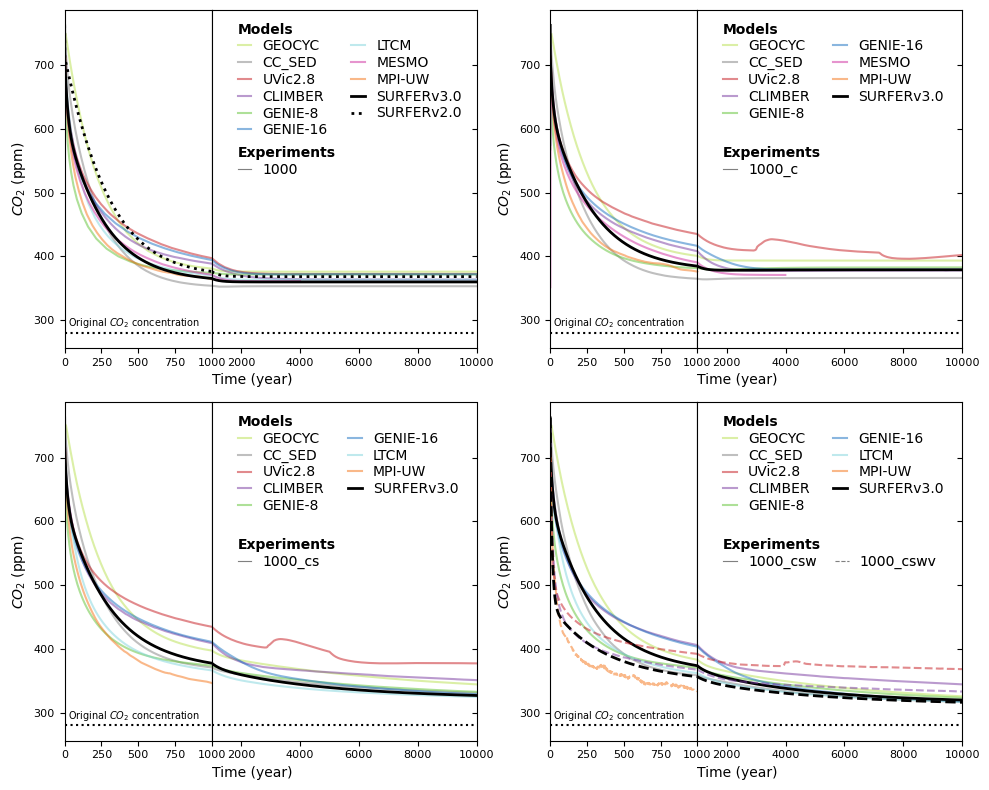

In [65]:
# Setting up the figure

LTMIP = [c1000,c1000_c,c1000_cs,c1000_csw,c1000_cswv]
surfer = [sol,sol_c,sol_cs,sol_csw,sol_cswv]
exp_title = ['1000','1000_c','1000_cs','1000_csw','1000_cswv']
exp_index = [0,1,2,3]
alpha_value=0.5
lw_value=2

N =10001
time = np.linspace(0,10000,N)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=[1,9/5,0.5,1,9/5], height_ratios = [1,1] )

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])

ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 3])
ax8 = fig.add_subplot(gs[1, 4])

ax_list = fig.axes
Legends = []

# Plot different data for _,C,CS,CSW experiments

for i in range(0,4) : 
    
    # LTMIP
    for j in range(0,9):
        if i<3 : 
            if np.isnan(LTMIP[exp_index[i]][100,j]) == False :
                ax_list[i*2].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',alpha=alpha_value)
                ax_list[i*2+1].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)
        else :
            if j != 7 :
                ax_list[i*2].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',alpha=alpha_value)
                ax_list[i*2+1].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)
    
    #SURFER
    ax_list[i*2].plot(surfer[exp_index[i]].t,PgCtoppm(surfer[exp_index[i]].y[0]),'k',lw=lw_value)
    ax_list[i*2+1].plot(surfer[exp_index[i]].t,PgCtoppm(surfer[exp_index[i]].y[0]),'k',lw=lw_value,label='SURFERv3.0')
    
# Plot data for CSWV experiment

for j in range(0,9):
    ax_list[6].plot(time,LTMIP[4][:,j],c=CC[j],ls='--',alpha=alpha_value)
    ax_list[7].plot(time,LTMIP[4][:,j],c=CC[j],ls='--',alpha=alpha_value)

ax_list[6].plot(surfer[4].t,PgCtoppm(surfer[4].y[0]),'k--',lw=lw_value)
ax_list[7].plot(surfer[4].t,PgCtoppm(surfer[4].y[0]),'k--',lw=lw_value)


# Plot SURFERv2.0 data

ax_list[0].plot(SURFERv2_LTMIP[0],SURFERv2_LTMIP[1],'k:',lw=lw_value)
ax_list[1].plot(SURFERv2_LTMIP[0],SURFERv2_LTMIP[1],'k:',lw=lw_value,label = 'SURFERv2.0')

 # Figure properties and legend

for i in range(0,4) :
    
    ax_list[i*2].set_xlim((0,1000))
    ax_list[i*2].axhline(280,0,1,c='k',ls=':')
    ax_list[i*2].annotate(r'Original $CO_2$ concentration', (20,290),fontsize=7)
    ax_list[i*2].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2].set_ylabel(r'$CO_2$ (ppm)')
    
    ax_list[i*2+1].set_xlim((1000,10000))
    ax_list[i*2+1].axhline(280,0,1,c='k',ls=':')
    ax_list[i*2+1].tick_params(left=False)
    ax_list[i*2+1].tick_params(labelleft=False)
    ax_list[i*2+1].tick_params(axis = 'y',right=True, direction = 'in')# don't put tick labels at the top  

    # legend
    
    lines = ax_list[i*2+1].get_lines()
    first_legend = ax_list[i*2+1].legend(loc = 'upper left',bbox_to_anchor=(0.05,0.5,.9,0.5),fontsize=10,labelspacing=0.2,ncol = 2, handlelength = 1, title = 'Models',alignment ='left',edgecolor='none', title_fontproperties = {'weight':'bold'},columnspacing=1.7)
    line, = ax_list[i*2+1].plot([],[], color='gray',ls='-',lw='0.8',label=f'{exp_title[i]}')
    second_legend = ax_list[i*2+1].legend(handles = [line],loc = 'lower left',bbox_to_anchor=(0.05,0.47,.9,0.5),fontsize=10,labelspacing=0.2,ncol = 2, handlelength = 1, title = 'Experiments',alignment ='left',edgecolor='none', title_fontproperties = {'weight':'bold'},columnspacing=1.7)
    
    if i == 3 :
        line2, = ax_list[i*2+1].plot([],[], color='gray',ls='--',lw='0.8',label=f'{exp_title[4]}')
        second_legend = ax_list[i*2+1].legend(handles = [line,line2],loc = 'lower left',bbox_to_anchor=(0.05,0.47,.9,0.5),fontsize=10,labelspacing=0.2,ncol = 2, handlelength = 1, title = 'Experiments',alignment ='left',edgecolor='none', title_fontproperties = {'weight':'bold'},columnspacing=1.3)
    
    ax_list[i*2+1].add_artist(first_legend)
    ax_list[i*2+1].add_artist(second_legend)
    ax_list[i*2+1].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2+1].set_xlabel(r'Time (year)',loc='left')
    
plt.tight_layout()
fig.subplots_adjust(wspace=0) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig09.pdf'),bbox_inches='tight')


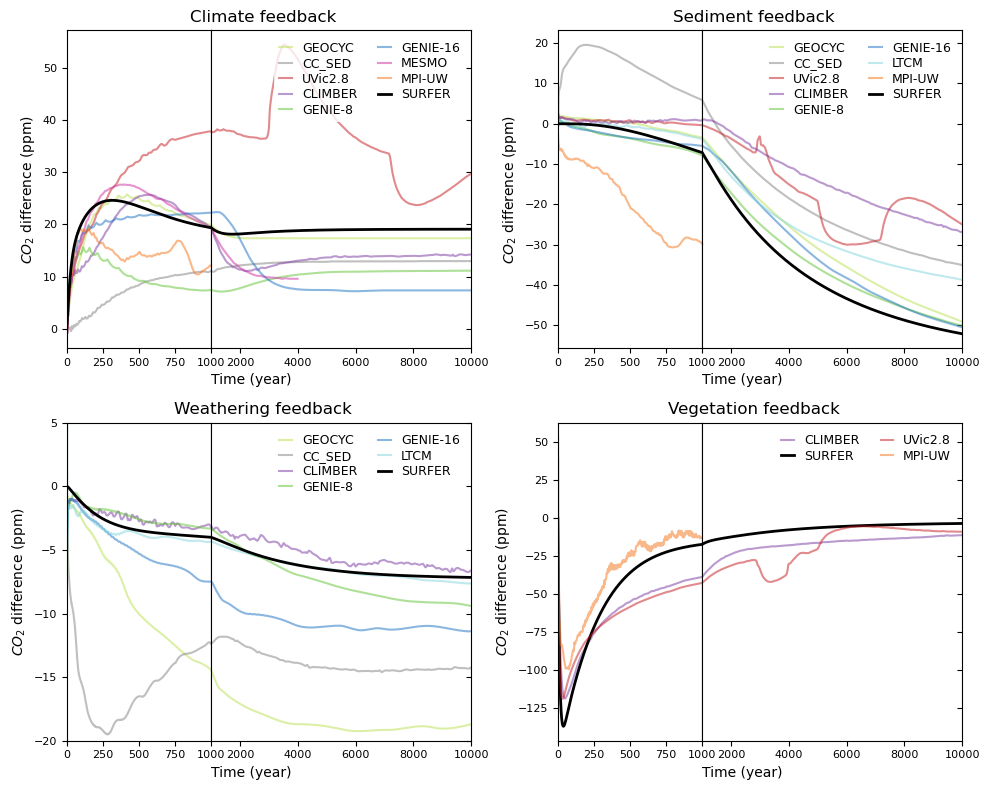

In [66]:
titles = ['Climate feedback','Sediment feedback','Weathering feedback','Vegetation feedback']

N =10001
time = np.linspace(0,10000,N)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=[1,9/5,0.6,1,9/5], height_ratios = [1,1] )

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])

ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 3])
ax8 = fig.add_subplot(gs[1, 4])

ax_list = fig.axes
Legends = []

# Plot climate, sediment and weathering feedbacks

for i in range(0,4) : 
    
    #LTMIP
    for j in range(0,9):
        if i == 1 and j == 6 :
            ax_list[i*2].plot(time,LTMIP[2][:,j]-LTMIP[0][:,j],c=CC[j],ls='-',alpha=alpha_value)
            ax_list[i*2+1].plot(time,LTMIP[2][:,j]-LTMIP[0][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)
            
        if np.isnan(LTMIP[i+1][100,j]-LTMIP[i][100,j]) == False :
            ax_list[i*2].plot(time,LTMIP[i+1][:,j]-LTMIP[i][:,j],c=CC[j],ls='-',alpha=alpha_value)
            ax_list[i*2+1].plot(time,LTMIP[i+1][:,j]-LTMIP[i][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)

    #SURFER
    ax_list[i*2].plot(surfer[i+1].t,PgCtoppm(surfer[i+1].y[0]-surfer[i].y[0]),'k',lw=lw_value)
    ax_list[i*2+1].plot(surfer[i+1].t,PgCtoppm(surfer[i+1].y[0]-surfer[i].y[0]),'k',label='SURFER',lw=lw_value)
    
    
# PLot vegetation feedback
    
for j in [2,8]:
    ax_list[6].plot(time,LTMIP[4][:,j]-LTMIP[2][:,j],c=CC[j],ls='-',alpha=alpha_value)
    ax_list[7].plot(time,LTMIP[4][:,j]-LTMIP[2][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)

# Figure properties and legend

for i in range(0,4) :


    ax_list[i*2].set_xlim((0,1000))
    ax_list[i*2].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2].set_ylabel(r'$CO_2$ difference (ppm)')
    
    ax_list[i*2+1].set_xlim((1000,10000))
    ax_list[i*2+1].tick_params(left=False)
    ax_list[i*2+1].tick_params(labelleft=False)
    ax_list[i*2+1].tick_params(axis = 'y',right=True, direction = 'in')# don't put tick labels at the top

    # legend
    
    ax_list[i*2+1].legend(loc = 'best',fontsize=9,labelspacing=0.2,ncol = 2, handlelength = 1,edgecolor='none',columnspacing=1.7)
    ax_list[i*2+1].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2+1].set_xlabel(r'Time (year)',loc='left')
    ax_list[i*2+1].set_title(f'{titles[i]}',x=0.2)

ax_list[7].legend(loc = 'best',fontsize=9,labelspacing=0.2,ncol = 2, handlelength = 1,edgecolor='none',columnspacing=1.7)

ax_list[4].set_ylim((-20,5))
ax_list[5].set_ylim((-20,5))

plt.tight_layout()
fig.subplots_adjust(wspace=0) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig011.pdf'),bbox_inches='tight')

#### 5000 PgC pulse

In [67]:
t0=0 ; tend=10000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi+5000,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]
model_params = params_setup()
model_params_noveg = params_setup(K_AL=0)

# 5 experiments

sol      =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = False, sediments=False,weathering = False)
sol_c    =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = True, sediments=False,weathering = False)
sol_cs   =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = False)
sol_csw  =  SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)
sol_cswv =  SURFER(zero_emissions,y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

# accumulation for CS experiment 

H_D, CO3_D, HCO3_D, H2CO3_D, OH_D, BOH4_D = vspecies_from_DICALK_masses(sol_cs.y[4],sol_cs.y[7],T_D+sol_cs.y[11],S_D, level = 'D')
acc_5000 = F_CaCO3_pi+F_CaSiO3_pi - (alpha_diss*(CO3_D-CO32D_pi)+beta_diss*(sol_cs.y[8]-MS_pi)+gamma_diss*(CO3_D-CO32D_pi)*(sol_cs.y[8]-MS_pi))

# DIC and ALK for CS experiment

DIC_5000 = (sol_cs.y[2]+sol_cs.y[3]+sol_cs.y[4])*10**21/mass_o/12
ALK_5000 = (sol_cs.y[5]+sol_cs.y[6]+sol_cs.y[7])*10**21/mass_o/12

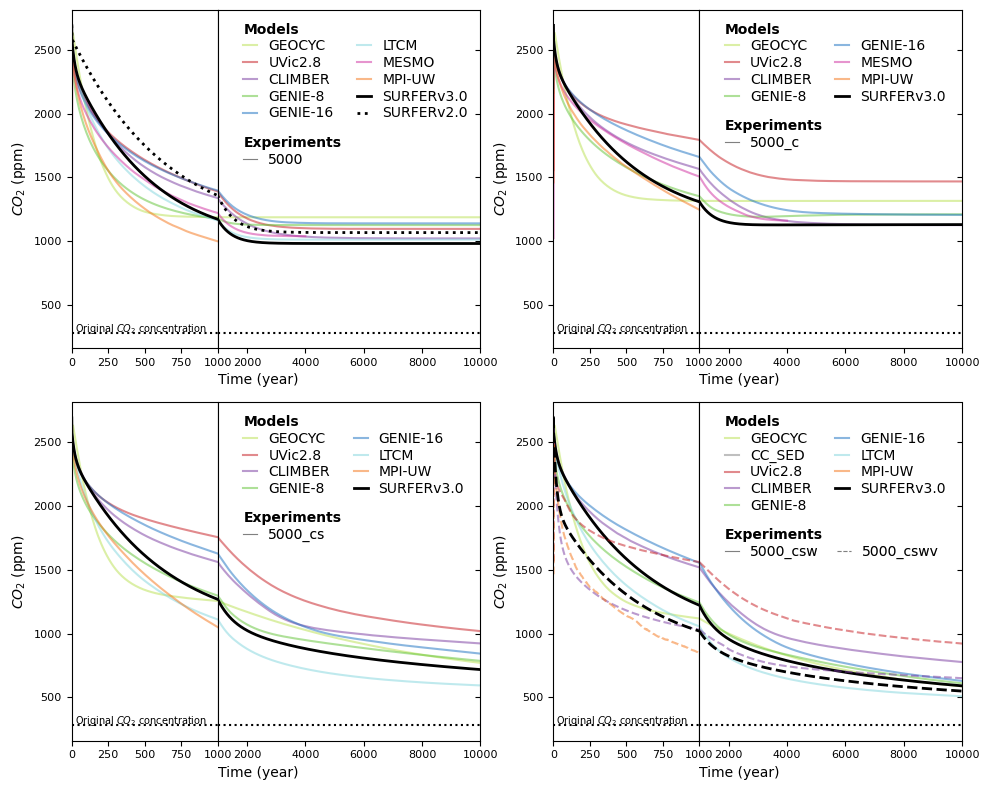

In [68]:
# Setting up the figure

LTMIP = [c5000,c5000_c,c5000_cs,c5000_csw,c5000_cswv]
surfer = [sol,sol_c,sol_cs,sol_csw,sol_cswv]
exp_title = ['5000','5000_c','5000_cs','5000_csw','5000_cswv']
exp_index = [0,1,2,3]
alpha_value=0.5
lw_value=2

N =10001
time = np.linspace(0,10000,N)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=[1,9/5,0.5,1,9/5], height_ratios = [1,1] )

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])

ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 3])
ax8 = fig.add_subplot(gs[1, 4])

ax_list = fig.axes
Legends = []

# Plot different data for _,C,CS,CSW experiments

for i in range(0,4) : 
    
    # LTMIP
    for j in range(0,9):
        if i<3 : 
            if np.isnan(LTMIP[exp_index[i]][100,j]) == False :
                ax_list[i*2].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',alpha=alpha_value)
                ax_list[i*2+1].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)
        else :
            if j != 7 :
                ax_list[i*2].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',alpha=alpha_value)
                ax_list[i*2+1].plot(time,LTMIP[exp_index[i]][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)
   
    #SURFER
    ax_list[i*2].plot(surfer[exp_index[i]].t,PgCtoppm(surfer[exp_index[i]].y[0]),'k',lw=lw_value)
    ax_list[i*2+1].plot(surfer[exp_index[i]].t,PgCtoppm(surfer[exp_index[i]].y[0]),'k',lw=lw_value,label='SURFERv3.0')
    
# Plot data for CSWV experiment

for j in range(0,9):
    ax_list[6].plot(time,LTMIP[4][:,j],c=CC[j],ls='--',alpha=alpha_value)
    ax_list[7].plot(time,LTMIP[4][:,j],c=CC[j],ls='--',alpha=alpha_value)

ax_list[6].plot(surfer[4].t,PgCtoppm(surfer[4].y[0]),'k--',lw=lw_value)
ax_list[7].plot(surfer[4].t,PgCtoppm(surfer[4].y[0]),'k--',lw=lw_value)


# Plot SURFERv2.0 data

ax_list[0].plot(SURFERv2_LTMIP[0],SURFERv2_LTMIP[2],'k:',lw=lw_value)
ax_list[1].plot(SURFERv2_LTMIP[0],SURFERv2_LTMIP[2],'k:',lw=lw_value,label = 'SURFERv2.0')

 # Figure properties and legend

for i in range(0,4) :
    
    ax_list[i*2].set_xlim((0,1000))
    ax_list[i*2].axhline(280,0,1,c='k',ls=':')
    ax_list[i*2].annotate(r'Original $CO_2$ concentration', (20,290),fontsize=7)
    ax_list[i*2].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2].set_ylabel(r'$CO_2$ (ppm)')
    
    ax_list[i*2+1].set_xlim((1000,10000))
    ax_list[i*2+1].axhline(280,0,1,c='k',ls=':')
    ax_list[i*2+1].tick_params(left=False)
    ax_list[i*2+1].tick_params(labelleft=False)
    ax_list[i*2+1].tick_params(axis = 'y',right=True, direction = 'in')# don't put tick labels at the top  

    # legend
    
    lines = ax_list[i*2+1].get_lines()
    first_legend = ax_list[i*2+1].legend(loc = 'upper left',bbox_to_anchor=(0.05,0.5,.9,0.5),fontsize=10,labelspacing=0.2,ncol = 2, handlelength = 1, title = 'Models',alignment ='left',edgecolor='none', title_fontproperties = {'weight':'bold'},columnspacing=1.7)
    line, = ax_list[i*2+1].plot([],[], color='gray',ls='-',lw='0.8',label=f'{exp_title[i]}')
    second_legend = ax_list[i*2+1].legend(handles = [line],loc = 'lower left',bbox_to_anchor=(0.05,0.55,.9,0.5),fontsize=10,labelspacing=0.2,ncol = 2, handlelength = 1, title = 'Experiments',alignment ='left',edgecolor='none', title_fontproperties = {'weight':'bold'},columnspacing=1.7)

    if i == 0 :
         second_legend = ax_list[i*2+1].legend(handles = [line],loc = 'lower left',bbox_to_anchor=(0.05,0.5,.9,0.5),fontsize=10,labelspacing=0.2,ncol = 2, handlelength = 1, title = 'Experiments',alignment ='left',edgecolor='none', title_fontproperties = {'weight':'bold'},columnspacing=1.7)

        
    if i == 3 :
        line2, = ax_list[i*2+1].plot([],[], color='gray',ls='--',lw='0.8',label=f'{exp_title[4]}')
        second_legend = ax_list[i*2+1].legend(handles = [line,line2],loc = 'lower left',bbox_to_anchor=(0.05,0.5,.9,0.5),fontsize=10,labelspacing=0.2,ncol = 2, handlelength = 1, title = 'Experiments',alignment ='left',edgecolor='none', title_fontproperties = {'weight':'bold'},columnspacing=1.3)
    
    ax_list[i*2+1].add_artist(first_legend)
    ax_list[i*2+1].add_artist(second_legend)
    ax_list[i*2+1].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2+1].set_xlabel(r'Time (year)',loc='left')
    
plt.tight_layout()
fig.subplots_adjust(wspace=0) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig10.pdf'),bbox_inches='tight')


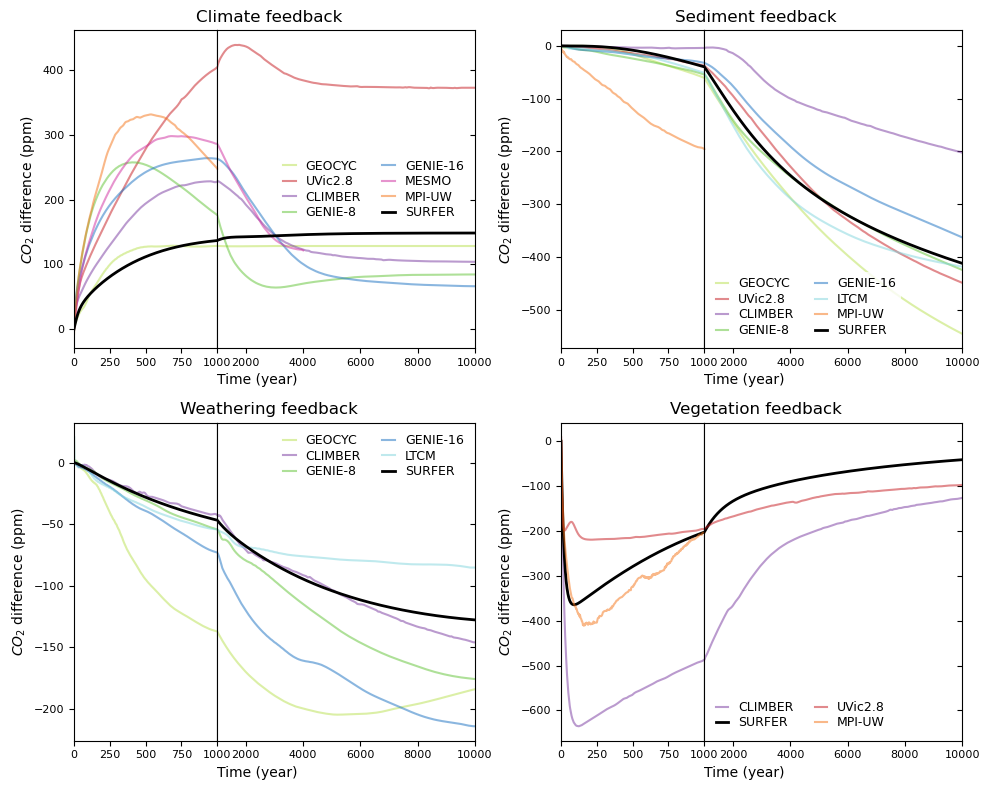

In [69]:
titles = ['Climate feedback','Sediment feedback','Weathering feedback','Vegetation feedback']

N =10001
time = np.linspace(0,10000,N)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=[1,9/5,0.6,1,9/5], height_ratios = [1,1] )

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])

ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 3])
ax8 = fig.add_subplot(gs[1, 4])

ax_list = fig.axes
Legends = []

# Plot climate, sediment and weathering feedbacks

for i in range(0,4) : 
    
    #LTMIP
    for j in range(0,9):
        if i == 1 and j == 6 :
            ax_list[i*2].plot(time,LTMIP[2][:,j]-LTMIP[0][:,j],c=CC[j],ls='-',alpha=alpha_value)
            ax_list[i*2+1].plot(time,LTMIP[2][:,j]-LTMIP[0][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)
            
        if np.isnan(LTMIP[i+1][100,j]-LTMIP[i][100,j]) == False :
            ax_list[i*2].plot(time,LTMIP[i+1][:,j]-LTMIP[i][:,j],c=CC[j],ls='-',alpha=alpha_value)
            ax_list[i*2+1].plot(time,LTMIP[i+1][:,j]-LTMIP[i][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)

    #SURFER
    ax_list[i*2].plot(surfer[i+1].t,PgCtoppm(surfer[i+1].y[0]-surfer[i].y[0]),'k',lw=lw_value)
    ax_list[i*2+1].plot(surfer[i+1].t,PgCtoppm(surfer[i+1].y[0]-surfer[i].y[0]),'k',label='SURFER',lw=lw_value)
    
    
# PLot vegetation feedback
    
for j in [2,8]:
    ax_list[6].plot(time,LTMIP[4][:,j]-LTMIP[2][:,j],c=CC[j],ls='-',alpha=alpha_value)
    ax_list[7].plot(time,LTMIP[4][:,j]-LTMIP[2][:,j],c=CC[j],ls='-',label=labels[j],alpha=alpha_value)

# Figure properties and legend

for i in range(0,4) :


    ax_list[i*2].set_xlim((0,1000))
    ax_list[i*2].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2].set_ylabel(r'$CO_2$ difference (ppm)')
    
    ax_list[i*2+1].set_xlim((1000,10000))
    ax_list[i*2+1].tick_params(left=False)
    ax_list[i*2+1].tick_params(labelleft=False)
    ax_list[i*2+1].tick_params(axis = 'y',right=True, direction = 'in')# don't put tick labels at the top

    # legend
    
    ax_list[i*2+1].legend(loc = 'best',fontsize=9,labelspacing=0.2,ncol = 2, handlelength = 1,edgecolor='none',columnspacing=1.7)
    ax_list[i*2+1].tick_params(axis = 'both', labelsize = 8)
    ax_list[i*2+1].set_xlabel(r'Time (year)',loc='left')
    ax_list[i*2+1].set_title(f'{titles[i]}',x=0.2)

ax_list[7].legend(loc = 'best',fontsize=9,labelspacing=0.2,ncol = 2, handlelength = 1,edgecolor='none',columnspacing=1.7)

plt.tight_layout()
fig.subplots_adjust(wspace=0) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig12.pdf'),bbox_inches='tight')

#### Accumulation fluxes

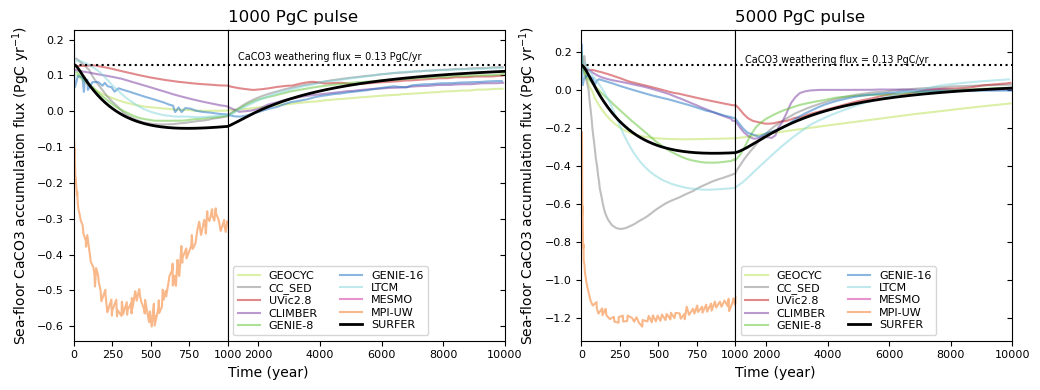

In [70]:
# Setting up figure

fig = plt.figure(figsize=(10.5,4))
gs = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[1,9/5,0.5,1,9/5])


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])

# Plot LTMIP data

X1 = c1000_burrial
X2 = c5000_burrial

N =10001
time = np.linspace(0,10000,N)

for i in range(0,9):
    ax1.plot(time,X1[:,i],c=CC[i],ls='-',alpha=alpha_value)
    ax2.plot(time,X1[:,i],c=CC[i],ls='-',label=labels[i],alpha=alpha_value)
    
    ax3.plot(time,X2[:,i],c=CC[i],ls='-',alpha=alpha_value)
    ax4.plot(time,X2[:,i],c=CC[i],ls='-',label=labels[i],alpha=alpha_value)

# Plot SURFER3.0 outputs

t0=0 ; tend=10000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

ax1.plot(sol_cs.t,acc_1000,'k',zorder=15,lw=lw_value)
ax2.plot(sol_cs.t,acc_1000,'k',zorder=15,label='SURFER',lw=lw_value)

ax3.plot(sol_cs.t,acc_5000,'k',zorder=15,lw=lw_value)
ax4.plot(sol_cs.t,acc_5000,'k',zorder=15,label='SURFER',lw=lw_value)

# figure settings

ax1.set_xlim((0,1000))
ax2.set_xlim((1000,10000))
ax3.set_xlim((0,1000))
ax4.set_xlim((1000,10000))

ax2.tick_params(left=False)
ax2.tick_params(labelleft=False)
ax2.tick_params(axis = 'y',right=True, direction = 'in')# don't put tick labels at the top
ax2.legend(fontsize=8,labelspacing=0.2,ncol = 2)

ax4.tick_params(left=False)
ax4.tick_params(labelleft=False)
ax4.tick_params(axis = 'y',right=True, direction = 'in')# don't put tick labels at the top
ax4.legend(fontsize=8,labelspacing=0.2,ncol = 2)

ax1.axhline(0.13,0,1,c='k',ls=':')
ax2.axhline(0.13,0,1,c='k',ls=':')
ax3.axhline(0.13,0,1,c='k',ls=':')
ax4.axhline(0.13,0,1,c='k',ls=':')

ax1.tick_params(axis = 'both', labelsize = 8)
ax2.tick_params(axis = 'both', labelsize = 8)
ax2.annotate(r'CaCO3 weathering flux = 0.13 PgC/yr', (1330,0.143),fontsize=7)

ax3.tick_params(axis = 'both', labelsize = 8)
ax4.tick_params(axis = 'both', labelsize = 8)
ax4.annotate(r'CaCO3 weathering flux = 0.13 PgC/yr', (1330,0.143),fontsize=7)

ax1.set_ylabel(r'Sea-floor CaCO3 accumulation flux ($\mathrm{PgC~yr^{-1}}$)')
ax2.set_xlabel(r'Time (year)',loc='left')
ax2.set_title(r'1000 PgC pulse',loc='left')

ax3.set_ylabel(r'Sea-floor CaCO3 accumulation flux ($\mathrm{PgC~yr^{-1}}$)')
ax4.set_xlabel(r'Time (year)',loc='left')
ax4.set_title(r'5000 PgC pulse',loc='left')

plt.tight_layout()
fig.subplots_adjust(wspace=0) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig13.pdf'),bbox_inches='tight')

## cGENIE 

We compare SURFER v3 with 1 Myr runs from the cGENIE model of intermediate complexity. These runs were perfromed in [Lord et al. (2016)](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014GB005074). The data from cGENIE is accessible through personnal correspondance with Natalie Lord, and not included in the figures here.

We first define a parametrisation for the solubility constant of calcite, necessary to compute the saturation state with repsect to calcite.

In [71]:
def k_calcite_sp(T,S) :
    lnksp = -395.8263+6537.773/T+71.595*np.log(T)-0.17959*T + 1*(-1.78938+410.64/T+0.006543*T)*S**0.5-0.17755*S+0.0094979*S**1.5
    return np.exp(lnksp)

def k_calcite_sp_p(T,S,z) : 
    TC = T-273.15
    lnksp = -395.8263+6537.773/T+71.595*np.log(T)-0.17959*T + 1*(-1.78938+410.64/T+0.006543*T)*S**0.5-0.17755*S+0.0094979*S**1.5
    ksp_0 = np.exp(lnksp)
    dV = -48.76 -0.5304*TC
    dK = (-11.76 + 0.3692*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return ksp_0*np.exp(C)

ca = 0.01028 # Ca++ mol/kg and not µmol/kg as said in Sarmiento and Gruber (2006)

In [72]:
teval = np.logspace(0,np.log10(1000001),1000)-1
emission_pulse =np.linspace(1000,20000,20)
SURFER_quantities=np.zeros((6,20,1000))

model_params_noveg = params_setup(K_AL=0)

# SURFER v3.0 runs for the 20 emission pulses. 

for i in range(0,20) : 

    y0 = [MA_pi+emission_pulse[i],ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]
    sol = SURFER(zero_emissions,y0,teval,model_params_noveg,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

    H_U, CO3_U, HCO3_U, H2CO3_U, OH_U, BOH4_U = vspecies_from_DICALK_masses(sol.y[2],sol.y[5],T_U+sol.y[9],S_U, level = 'U')
    H_D, CO3_D, HCO3_D, H2CO3_D, OH_D, BOH4_D = vspecies_from_DICALK_masses(sol.y[4],sol.y[7],T_D+sol.y[11],S_D, level = 'D')
    
    ksp = k_calcite_sp_p(T_U+sol.y[9],S_U,ZU)
    CO3_U_sat = ksp*10**6/ca

    SURFER_quantities[0,i,:] = PgCtoppm(sol.y[0])
    SURFER_quantities[1,i,:] = sol.y[9]
    SURFER_quantities[2,i,:] = CO3_U/CO3_U_sat
    SURFER_quantities[3,i,:] = (F_CaCO3_pi*(1+K_Ca*sol.y[9]) + F_CaSiO3_pi*np.exp(K_T*sol.y[9]))/carbon_molar_mass # Tmol/yr
    SURFER_quantities[4,i,:] = -np.log10(H_U)
    SURFER_quantities[5,i,:] = sol.y[8]
    
    print(f'\r{(i+1)/20*100:.2f}% completed', end='') 


100.00% completed

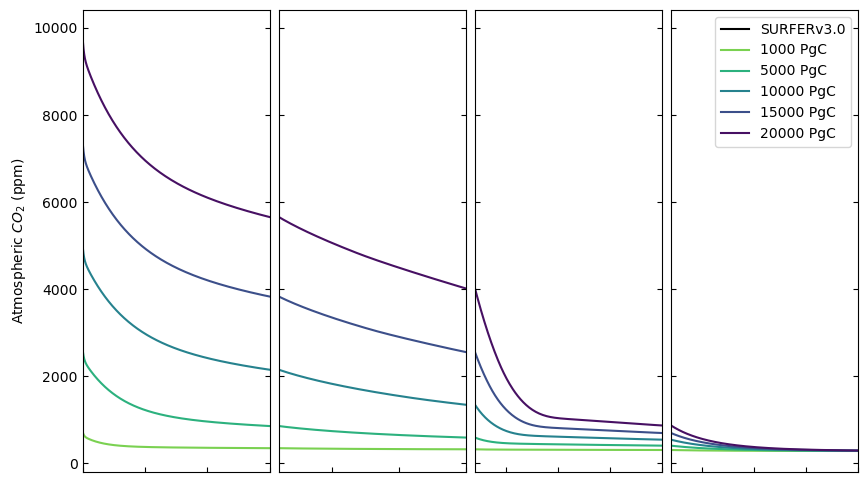

In [73]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1])
cmap = matplotlib.colormaps.get_cmap('viridis')

fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(10,6),gridspec_kw=gs_kw)

quantity_index = 0

# 0 - pCO2 (ppm)
# 1 - surface temperature increase (°C)
# 2 - surface calcite CO3-- saturation state
# 3 - Ca weahtering flux (Tmol/yr)
# 4 - ocean surface pH
# 5 - sediments erdibl CaCO3 mass (PgC)

for i in [0,4,9,14,19]: 
    
    for axes in [ax1,ax2,ax3,ax4] : 
        axes.plot(teval,SURFER_quantities[quantity_index,i],color=cmap(0.8-i/20*0.8),zorder=0,ls='-')
  
ax1.set_xlim((0,3000))
ax2.set_xlim((3000,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,1000000))


ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
        
ax1.set_xticks([0,1000,2000,3000])
ax1.set_xticklabels(['0','1000','2000','  3000'])
ax2.set_xticks([5000,7500,10000])
ax2.set_xticklabels(['5k','7.5k','  10k'])
ax3.set_xticks([25000,50000,75000,100000])
ax3.set_xticklabels(['25k','50k','75k','  100k'])
ax4.set_xticks([250000,500000,750000,1000000])
ax4.set_xticklabels(['250k','500k','750k','1m'])

ax1.set_ylabel(r'Atmospheric $CO_2$ (ppm)')

ax4.plot([],[],c='k',ls='-',label='SURFERv3.0')

for i in [0,4,9,14,19]: 
    ax4.plot([],[],c=cmap(0.8-i/20*0.8),ls='-',label='%.f PgC'%(emission_pulse[i]))

ax4.legend(fontsize=10)

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig14.pdf'),bbox_inches='tight')


<>:19: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\O'
C:\Users\AL000111\AppData\Local\Temp\ipykernel_2984\3237314798.py:19: SyntaxWarning: invalid escape sequence '\O'
  r'Surface saturation rate wrt.''\n''calcite ($\Omega$)',


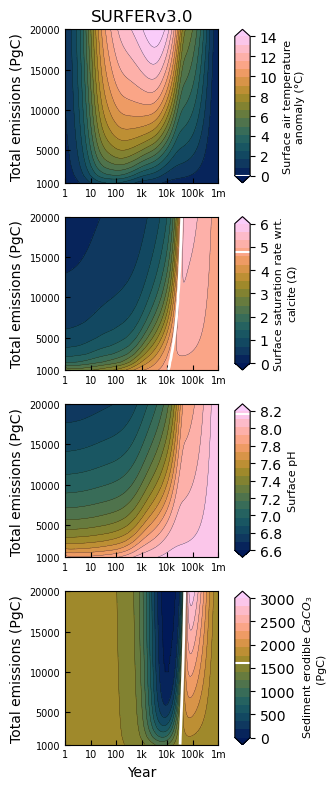

In [74]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, figsize=(4,8))

axes = [ax1,ax2,ax3,ax4]
indexes = [1,2,4,5]
nlevels = 18

# SURFER
Levels_S = [np.linspace(0,14,nlevels),
            np.linspace(0,6,nlevels),
            np.linspace(6.6,8.2,nlevels),
            np.linspace(0,3000,nlevels)]

Ticks_S = [np.linspace(0,14,8),
           np.linspace(0,6,7),
           np.linspace(6.6,8.2,9),
           np.linspace(0,3000,7)]

labels_S = ['Surface air temperature''\n''anomaly (°C)',
            r'Surface saturation rate wrt.''\n''calcite ($\Omega$)',
            'Surface pH',
            ' Sediment erodible $CaCO_3$''\n''(PgC)']

H_U, CO3_U, HCO3_U, H2CO3_U, OH_U, BOH4_U = species_from_DICALK_masses(MU_pi,QU_pi,T_U,S_U, level = 'U')
H_D, CO3_D, HCO3_D, H2CO3_D, OH_D, BOH4_D = species_from_DICALK_masses(MD_pi,QD_pi,T_D,S_D, level = 'D')
ksp = k_calcite_sp_p(T_U,S_U,ZU)
CO3_U_sat = ksp*10**6/ca

pi_values_S = [0,CO3_U/CO3_U_sat,-np.log10(H_U),1600]

# Plots
for i in range(0,4):
    #SURFER
    cs = axes[i].contourf(teval,emission_pulse,SURFER_quantities[indexes[i]],levels = Levels_S[i],cmap='cmc.batlow',extend='both')
    axes[i].contour(teval,emission_pulse,SURFER_quantities[indexes[i]],levels = Levels_S[i],colors = 'k',linestyles = 'solid',linewidths = 0.2)
    cbar = fig.colorbar(cs,ax=axes[i],aspect=10, ticks=Ticks_S[i])
    cbar.set_label(label=labels_S[i],fontsize=8)
    axes[i].contour(teval,emission_pulse,SURFER_quantities[indexes[i]],levels = [pi_values_S[i]],colors = 'w',linestyles = 'solid',linewidths = 2)
    cbar.ax.plot([0, 1000000], [pi_values_S[i],pi_values_S[i]], 'w')

# figure aspect   
for axes in [ax1,ax2,ax3,ax4] : 
    axes.set_xscale('log')
    axes.set_box_aspect(1)
    axes.tick_params(direction = 'in')
    axes.set_xticks([1,10,100,1000,10000,100000,1000000])
    axes.set_xticklabels(['1','10','100','1k','10k','100k','1m'],fontsize=7)
    axes.set_yticks([1000,5000,10000,15000,20000])
    axes.set_yticklabels(['1000','5000','10000','15000','20000'],fontsize=7)
   
ax1.set_ylabel(r'Total emissions (PgC)')
ax2.set_ylabel(r'Total emissions (PgC)')
ax3.set_ylabel(r'Total emissions (PgC)')
ax4.set_ylabel(r'Total emissions (PgC)')

ax1.set_title('SURFERv3.0')

ax4.set_xlabel(r'Year')


plt.tight_layout()

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig15.pdf'),bbox_inches='tight')

## Ocean heat content and sea-level rise 

In [75]:
IPCC_ohc_slr = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/IPCC_ohc_slr.csv'), delimiter=',')

(-5.0, 50.0)

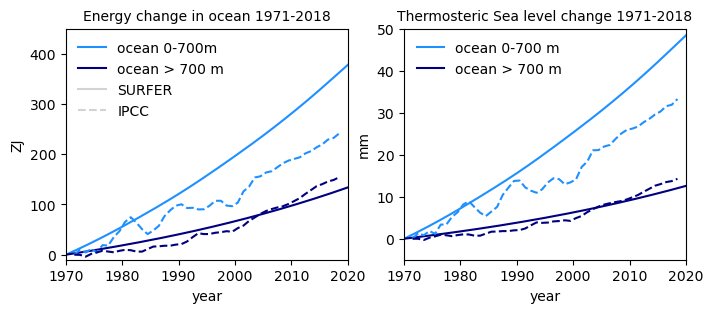

In [76]:

t0=1750; tend=2100;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]
model_params = params_setup()

sol =  SURFER(emissions_ssp(0),y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

Aocean = 361*10**12

cum_heat_uptake_U = hu*365*24*3600*Aocean/(10**21)*cvol*(sol.y[9])
cum_heat_uptake_I = hi*365*24*3600*Aocean/(10**21)*cvol*(sol.y[10])
cum_heat_uptake_D = hd*365*24*3600*Aocean/(10**21)*cvol*(sol.y[11])

fig, [ax,ax2] = plt.subplots(1,2,figsize=(8,3))

#ohc
ax.plot(sol.t,cum_heat_uptake_U-cum_heat_uptake_U[220]+cum_heat_uptake_I-cum_heat_uptake_I[220],'dodgerblue',label = 'ocean 0-700m')
ax.plot(sol.t,cum_heat_uptake_D-cum_heat_uptake_D[220],'navy',label = 'ocean > 700 m')
ax.plot(IPCC_ohc_slr[0],IPCC_ohc_slr[1],'dodgerblue',ls='--')
ax.plot(IPCC_ohc_slr[0],IPCC_ohc_slr[2],'navy',ls='--')

#slr
slrUI = (sol.y[9]*alpha_U*hu+sol.y[10]*alpha_I*hi)*1000
slrD = (sol.y[11]*alpha_D*hd)*1000
ax2.plot(sol.t,slrUI-slrUI[220],'dodgerblue',label = 'ocean 0-700 m')
ax2.plot(sol.t,slrD-slrD[220],'navy',label = 'ocean > 700 m')
ax2.plot(IPCC_ohc_slr[0],IPCC_ohc_slr[4],'dodgerblue',ls='--')
ax2.plot(IPCC_ohc_slr[0],IPCC_ohc_slr[5],'navy',ls='--')


#figure properties
ax.plot([],[],'lightgray', label = 'SURFER')
ax.plot([],[],'lightgray',ls = '--', label = 'IPCC')

ax.set_title('Energy change in ocean 1971-2018',fontsize=10)
ax2.set_title('Thermosteric Sea level change 1971-2018',fontsize=10)

ax.set_ylabel('ZJ')
ax.set_xlabel('year')
ax2.set_ylabel('mm')
ax2.set_xlabel('year')

ax.legend(edgecolor='none',facecolor='none')
ax2.legend(edgecolor='none',facecolor='none')

ax.set_xlim((1970,2020))
ax.set_ylim((-10,450))

ax2.set_xlim((1970,2020))
ax2.set_ylim((-5,50))

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig16.pdf'),bbox_inches='tight')

In [77]:
# upload data from UVic model
uvic28 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/uvic_2.8.csv'), delimiter=',',skip_header=2)
uvic29 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/uvic_2.9.csv'), delimiter=',',skip_header=2)
uvic28SLR = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/uvic_2.8_SLR.csv'), delimiter=',',skip_header=2)
uvic29SLR = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/uvic_2.9_SLR.csv'), delimiter=',',skip_header=2)

# create emission scenarios
emissions_1280 = np.zeros((6,len(uvic29[:553,0])))
emissions_1280[0] = uvic29[:553,0]
emissions_1280[1] = uvic29[:553,5]

emissions_3840 = np.zeros((6,len(uvic29[:553,0])))
emissions_3840[0] = uvic29[:553,0]
emissions_3840[1] = uvic29[:553,11]

scenarios = [emissions_1280,emissions_3840]

# upload data from SURFER v2.0
SURFERv2_stericSLR_1280 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURFERv2_stericSLR_1280.csv'), delimiter=",")
SURFERv2_stericSLR_3840 = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURFERv2_stericSLR_3840.csv'), delimiter=",")
SURFERv2_stericSLR = [SURFERv2_stericSLR_1280,SURFERv2_stericSLR_3840]


print(np.sum(emissions_1280[1])-1280)
print(np.sum(emissions_3840[1])-3840)

484.35300000000007
484.35100000000057


Text(0, 0.5, 'm')

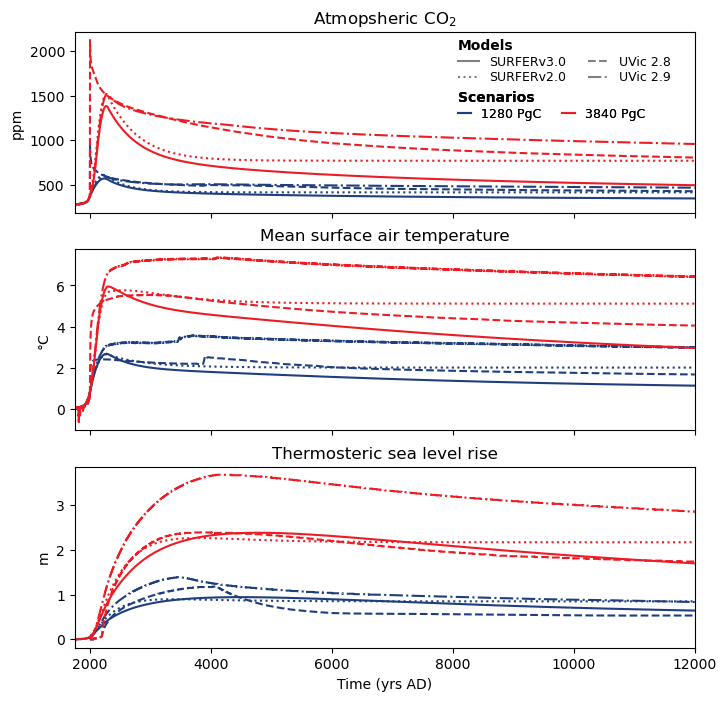

In [78]:
t0=1750; tend=12000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)


fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(8,8), sharex = True)

colors = ['#1f3e7d','#ed1c24']

ls_S ='-'
ls_S2 = ':'
ls_28 = '--'
ls_29 = '-.'

for k in range(0,2):

    # Run experiments in SURFER v3.0
    sol =  SURFER(scenarios[k],y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

    # Plot results for all models
    ax1.plot(sol.t,PgCtoppm(sol.y[0]), c=colors[k],ls = ls_S)
    ax1.plot(SURFERv2_stericSLR[k][0],SURFERv2_stericSLR[k][1], c=colors[k],ls = ls_S2)
    ax1.plot(uvic28[:,0],uvic28[:,12+k*4], c=colors[k],ls = ls_28)
    ax1.plot(uvic29[:,0],uvic29[:,6+k*6], c=colors[k],ls = ls_29)
    
    ax2.plot(sol.t,sol.y[9], c=colors[k],ls = ls_S)
    ax2.plot(SURFERv2_stericSLR[k][0],SURFERv2_stericSLR[k][2], c=colors[k],ls = ls_S2)
    ax2.plot(uvic28[:,0],(uvic28[:,11+k*4]-uvic28[0,11+k*4])/1.3, c=colors[k],ls = ls_28)
    ax2.plot(uvic29[:,0],uvic29[:,4+k*6]-uvic29[0,4+k*6], c=colors[k],ls = ls_29)

    slr = (sol.y[9]*alpha_U*hu+sol.y[10]*alpha_I*hi+sol.y[11]*alpha_D*hd)
    
    ax3.plot(sol.t,slr, c=colors[k],ls = ls_S)
    ax3.plot(SURFERv2_stericSLR[k][0],SURFERv2_stericSLR[k][3], c=colors[k],ls = ls_S2)
    ax3.plot(uvic28SLR[:,0],uvic28SLR[:,36+k*2], c=colors[k],ls = ls_28)
    ax3.plot(uvic29SLR[:,0],uvic29SLR[:,20+k*2], c=colors[k],ls = ls_29)

# Figure properties
m1, = ax1.plot([],[],'gray',ls = ls_S,label = 'SURFERv3.0')
m12, = ax1.plot([],[],'gray',ls = ls_S2,label = 'SURFERv2.0')
m2, = ax1.plot([],[],'gray',ls = ls_28,label = 'UVic 2.8')
m3, = ax1.plot([],[],'gray',ls = ls_29,label = 'UVic 2.9')
first_legend = ax1.legend([m1,m12,m2,m3],['SURFERv3.0','SURFERv2.0','UVic 2.8','UVic 2.9'],loc = 'lower left',bbox_to_anchor=(0.6,0.65),fontsize=9,labelspacing=0.2,ncol = 2, handlelength = 1.7, title = 'Models',alignment ='left',edgecolor='none', facecolor ='none',title_fontproperties = {'weight':'bold'},columnspacing=1.7)

l1, = ax1.plot([],[],color =colors[0],label ='1280 PgC')
l2, = ax1.plot([],[],color =colors[1],label ='3840 PgC')
second_legend = ax1.legend(handles= [l1,l2],loc = 'lower left',bbox_to_anchor=(0.6,0.45),fontsize=9,labelspacing=0.2,ncol = 3, handlelength = 1, title = 'Scenarios',alignment ='left',edgecolor='none', facecolor='none',title_fontproperties = {'weight':'bold'},columnspacing=1.7)

ax1.add_artist(first_legend)
ax1.add_artist(second_legend)

ax1.set_xlim((1750,12000))
# ax.set_ylim((0,3.8))
ax3.set_xlabel('Time (yrs AD)')

ax1.set_title(r'Atmopsheric CO$_2$')
ax2.set_title('Mean surface air temperature')
ax3.set_title('Thermosteric sea level rise')

ax1.set_ylabel(r'ppm')
ax2.set_ylabel(r'°C')
ax3.set_ylabel(r'm')

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig17.pdf'),bbox_inches='tight')

## Ice sheets

In [79]:
n = 1000
teval=np.logspace(np.log10(1750),5,n)
y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]
model_params = params_setup()

SURVERv3_SLR_temperature = np.zeros((6,n))
SURVERv3_SLR_GRIS = np.zeros((6,n))
SURVERv3_SLR_AIS = np.zeros((6,n))

SURVERv3_SLR_temperature[0] = teval
SURVERv3_SLR_GRIS[0] = teval
SURVERv3_SLR_AIS[0] = teval

for i in range(0,5) : 

    sol =  SURFER(emissions_ssp_CO2only(i),y0,teval,model_params,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

    SURVERv3_SLR_temperature[i+1] = sol.y[9]
    SURVERv3_SLR_GRIS[i+1] = sol.y[15]
    SURVERv3_SLR_AIS[i+1] = sol.y[16]



In [80]:
SURVERv2_SLR_temperature = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURVERv2_SLR_temperature.csv'), delimiter=',')
SURVERv2_SLR_GRIS = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURVERv2_SLR_GRIS.csv'), delimiter=',')
SURVERv2_SLR_AIS = np.genfromtxt(os.path.join(base_path, 'SURFER_v3/data/SURFERv2_data/SURVERv2_SLR_AIS.csv'), delimiter=',')

peak warming for SSP1-2.6 is :   v3.0: 1.6416537147534225   v2.0: 1.6987695091192807
peak warming for SSP2-4.5 is :   v3.0: 2.622609494687884   v2.0: 2.5781466354146665
peak warming for SSP4-6.0 is :   v3.0: 3.1781922867009924   v2.0: 3.1158001517042777
peak warming for SSP3-7.0 is :   v3.0: 5.417642144379343   v2.0: 5.184038824666611
peak warming for SSP5-8.5 is :   v3.0: 6.95606021949675   v2.0: 6.8719305553639325


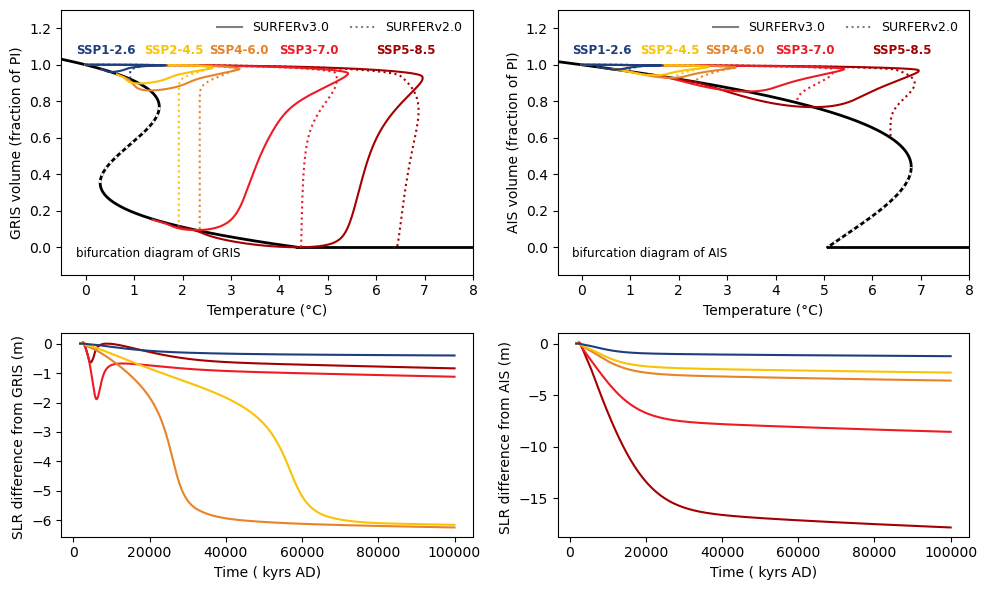

In [81]:
xG = np.linspace(-0.8,1.2,1000)
yG = -(-xG**3+a2G*xG**2+a1G*xG+c0G)/c1G

xA = np.linspace(-0.8,1.2,1000)
yA = -(-xA**3+a2A*xA**2+a1A*xA+c0A)/c1A

gs_kw = dict(width_ratios=[1,1],height_ratios=[1.3,1])
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,6),gridspec_kw=gs_kw)

maskG = (xG >= VmG) & (xG <= VpG)
ax1.plot(yG[xG>0],xG[xG>0],c='k',lw='2')
ax1.plot(yG[maskG],xG[maskG],c='w',lw='2',ls=':')
ax1.plot([yG[xG>0][0],17],[0,0],c='k',lw='2')

maskA = (xA >= VmA) & (xA <= VpA)
ax2.plot(yA[xA>0],xA[xA>0],c='k',lw='2')
ax2.plot(yA[maskA],xA[maskA],c='w',lw='2',ls=':')
ax2.plot([yA[xA>0][0],17],[0,0],c='k',lw='2')

labels = ['SSP1-2.6','SSP2-4.5','SSP4-6.0','SSP3-7.0','SSP5-8.5','SSP5-3.4']
colors = ['#1f3e7d','#fac205','#e78329','#ed1c24','#a40000','#ba91cc']

for i in range(0,5):
    
    ax1.plot(SURVERv3_SLR_temperature[i+1],SURVERv3_SLR_GRIS[i+1],color = colors[i],ls='-',zorder = 6-i)
    ax2.plot(SURVERv3_SLR_temperature[i+1],SURVERv3_SLR_AIS[i+1],color = colors[i],ls='-',zorder = 6-i)

    ax1.plot(SURVERv2_SLR_temperature[i+1],SURVERv2_SLR_GRIS[i+1],color = colors[i],ls=':',zorder = 6-i)
    ax2.plot(SURVERv2_SLR_temperature[i+1],SURVERv2_SLR_AIS[i+1],color = colors[i],ls=':',zorder = 6-i)
    
    ax3.plot(SURVERv3_SLR_GRIS[0],(SURVERv2_SLR_GRIS[i+1]-SURVERv3_SLR_GRIS[i+1])*SpotG,color = colors[i],ls='-',zorder = 6-i)
    ax4.plot(SURVERv3_SLR_AIS[0],(SURVERv2_SLR_AIS[i+1]-SURVERv3_SLR_AIS[i+1])*SpotA,color = colors[i],ls='-',zorder = 6-i)

    print('peak warming for',labels[i], 'is :   v3.0:', np.max(SURVERv3_SLR_temperature[i+1]),'  v2.0:',np.max(SURVERv2_SLR_temperature[i+1]))
    
ax1.set_xlim((-0.5,8))
ax1.set_ylim((-0.15,1.3))
ax2.set_xlim((-0.5,8))
ax2.set_ylim((-0.15,1.3))

label_xcoord = [-0.2,1.2,2.55,4,6]
for i in range(0,5) : 
    ax1.annotate(labels[i],(label_xcoord[i],1.06),color = colors[i],fontsize = 8.5, weight = 'bold')
    ax2.annotate(labels[i],(label_xcoord[i],1.06),color = colors[i],fontsize = 8.5, weight = 'bold')

ax1.annotate(r'bifurcation diagram of GRIS', (-0.2,-0.05),color = 'k',fontsize = 8.5)
ax1.plot([],[],c='gray', ls='-',label= 'SURFERv3.0')
ax1.plot([],[],c='gray', ls=':',label= 'SURFERv2.0')
ax1.legend(loc = 'upper right',fontsize=9,labelspacing=0.2,ncol = 2, handlelength = 2,alignment ='left',edgecolor='none', facecolor='none',columnspacing=1.7)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('GRIS volume (fraction of PI)')

ax2.annotate(r'bifurcation diagram of AIS', (-0.2,-0.05),color = 'k',fontsize = 8.5)
ax2.plot([],[],c='gray', ls='-',label= 'SURFERv3.0')
ax2.plot([],[],c='gray', ls=':',label= 'SURFERv2.0')
ax2.legend(loc = 'upper right',fontsize=9,labelspacing=0.2,ncol = 2, handlelength = 2,alignment ='left',edgecolor='none', facecolor='none',columnspacing=1.7)
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('AIS volume (fraction of PI)')

ax3.set_ylabel('SLR difference from GRIS (m) ')
ax4.set_ylabel('SLR difference from AIS (m) ')

ax3.set_xlabel('Time ( kyrs AD)')
ax4.set_xlabel('Time ( kyrs AD)')

plt.tight_layout()

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'fig17.pdf'),bbox_inches='tight')

## Sensitivity Analysis

In [82]:
# function to easily change model parameters for the sensitivity analysis
def mod_params(param_name,factor):

    default_params = params_setup()
    # Create a dictionary of the default parameters
    params_dict = dict(zip(params_setup.__code__.co_varnames, default_params))
    # Update the specific parameter
    params_dict[param_name] = params_dict[param_name] * factor
    # Call params_setup with the updated parameter
    varied_params = params_setup(**params_dict)

    return varied_params, params_dict[param_name]


In [83]:
cmap = matplotlib.colormaps.get_cmap('BrBG')

# function to perform and plot the sensitivity analysis
def sensitivity_plot(list_params,labels,param_mod,scaling_factor,ssp_index) :
    nrows = len(list_params)
    gs_kw = dict(width_ratios=[1,1,1,1,1],height_ratios=np.ones(nrows))
    fig, axes = plt.subplots(nrows,5, figsize=(10,2*nrows),gridspec_kw=gs_kw, sharex='col', sharey = True)
    teval=np.logspace(np.log10(1750),6,1000)
    targetColors = cmap(np.linspace(0,1,len(param_mod)))

    for i in range(0,nrows):

        for j in range(0,len(param_mod)) :

            params_SURFER, mod_param_value = mod_params(list_params[i],param_mod[j])
            DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A,params_SURFER[0],params_SURFER[1],params_SURFER[6])
            MU_pi_mod = DIC_U*WU*carbon_molar_mass*10**-18
            y0 = [MA_pi,ML_pi,MU_pi_mod,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]

            params_SURFER[9]=params_SURFER[7]  # K_alk_UI = K_UI
            params_SURFER[10]=params_SURFER[8] # K_alk_DI = K_DI

            if (params_SURFER[13]+params_SURFER[14]<1) and (params_SURFER[15]+params_SURFER[16]<1) :
                
                sol = SURFER(emissions_ssp(ssp_index),y0,teval,params_SURFER,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)
    
                for k in range(0,5):
    
                    zzorder= 0
                    if j == 4 : 
                        color_choice = 'k'
                        zzorder = 15
                    else : color_choice = targetColors[j]
                    
                    axes[i,k].plot(sol.t,PgCtoppm(sol.y[0]),color=color_choice,zorder=zzorder,label=r'%.3f'%(mod_param_value*scaling_factor[i]))

    axes[0,0].set_xlim((1950,2300))    
    axes[0,1].set_xlim((2300,3000))
    axes[0,2].set_xlim((3000,10000))
    axes[0,3].set_xlim((10000,100000))
    axes[0,4].set_xlim((100000,1000000))
    
    for k in range(0,nrows):
        axes[k,0].tick_params(direction = 'in',right=True)# don't put tick labels at the top
        axes[k,0].set_ylabel(r'$CO_2$ (ppm)')
        axes[k,4].legend(title = labels[k],title_fontsize=9,loc='upper left',bbox_to_anchor =(0.02,0.02,0.98,0.98),fontsize=8.5,labelspacing = 0.1, ncol = 2,handlelength = 1, edgecolor = 'none',facecolor='none', columnspacing = 1) 
    
        for m in range(1,5):
    
            axes[k,m].tick_params(direction = 'in',right = True)# don't put tick labels at the top
            axes[k,m].tick_params(labelleft=False)
    
    axes[nrows-1,0].set_xticks([1950,2100,2300])
    axes[nrows-1,0].set_xticklabels(['1950','2100','  2300'])
    axes[nrows-1,1].set_xticks([2650,3000])
    axes[nrows-1,1].set_xticklabels(['2650','  3000'])
    axes[nrows-1,2].set_xticks([6500,10000])
    axes[nrows-1,2].set_xticklabels(['6.5k','  10k'])
    axes[nrows-1,3].set_xticks([50000,100000])
    axes[nrows-1,3].set_xticklabels(['50k','  100k'])
    axes[nrows-1,4].set_xticks([500000,1000000])
    axes[nrows-1,4].set_xticklabels(['500k','1m'])
    
    axes[nrows-1,2].set_xlabel(r'Time (year AD)',loc='right')
    
    fig.subplots_adjust(wspace=0.05) 
    fig.subplots_adjust(hspace=0.1) 

    return fig




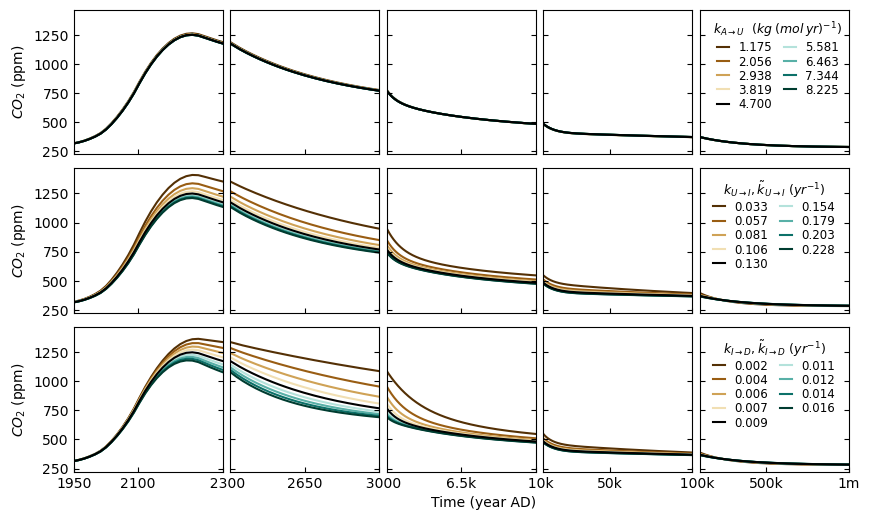

In [84]:
labels = [r'$k_{A\rightarrow U}$  ($kg\:(mol\:yr)^{-1}$)',
          r'$k_{U\rightarrow I},\tilde{k}_{U\rightarrow I}$ ($yr^{-1}$)',
          r'$k_{I\rightarrow D},\tilde{k}_{I\rightarrow D}$ ($yr^{-1}$)']
fig = sensitivity_plot(['K_AU','K_UI','K_ID'],labels,np.linspace(0.25,1.75,9),[1,1,1],3)

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_ocean.pdf'),bbox_inches='tight')


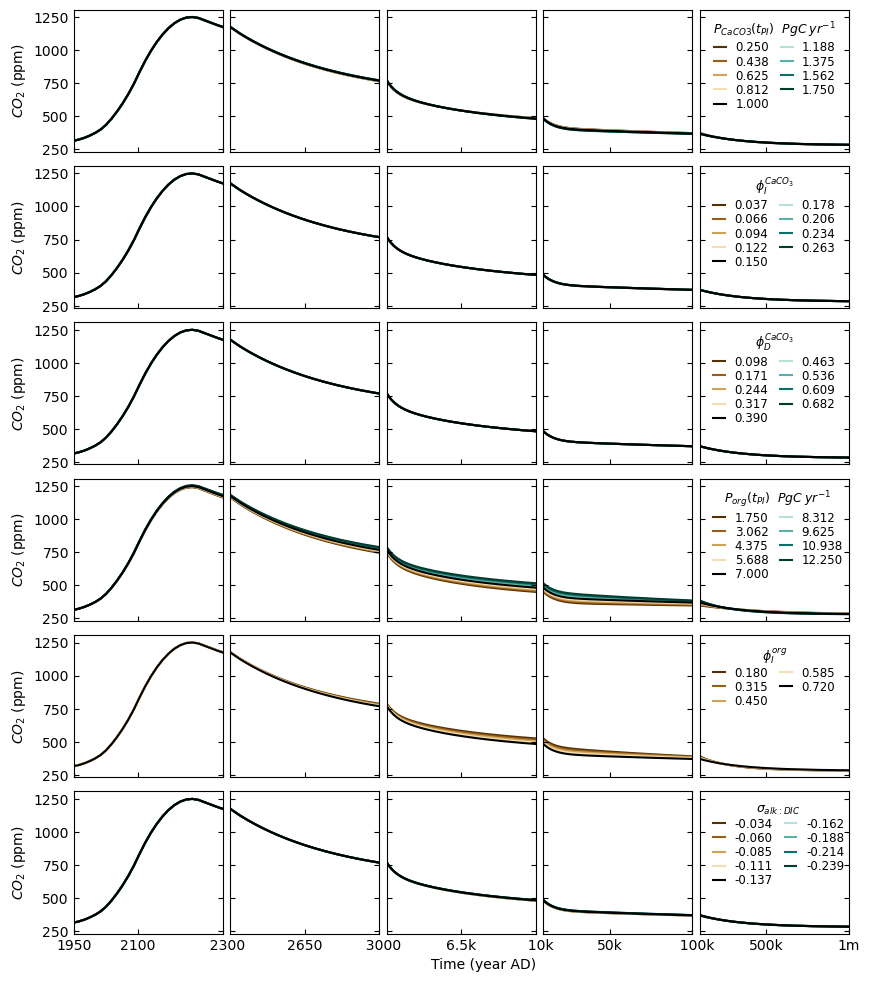

In [85]:
labels = [r'$P_{CaCO3}(t_{PI})$  $PgC\:yr^{-1}$',
          r'$\phi_I^{CaCO_3}$',
          r'$\phi_D^{CaCO_3}$',
          r'$P_{org}(t_{PI})$  $PgC\:yr^{-1}$',
          r'$\phi_I^{org}$',
          r'$\sigma_{alk:DIC}$']
fig = sensitivity_plot(['P_CaCO3_pi','phi_I_CaCO3_pi','phi_D_CaCO3_pi','P_org_pi','phi_I_org_pi','sigma_ALKDIC'],labels,np.linspace(0.25,1.75,9),[1,1,1,1,1,1],3)

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_pumps.pdf'),bbox_inches='tight')

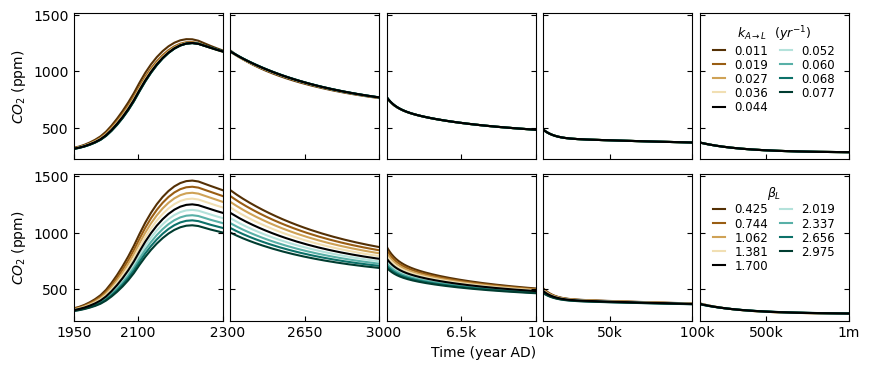

In [86]:
labels = [r'$k_{A \rightarrow L}$  ($yr^{-1}$)',
          r'$\beta_L$']
fig = sensitivity_plot(['K_AL','beta_L'],labels,np.linspace(0.25,1.75,9),[1,1],3)

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_veg.pdf'),bbox_inches='tight')

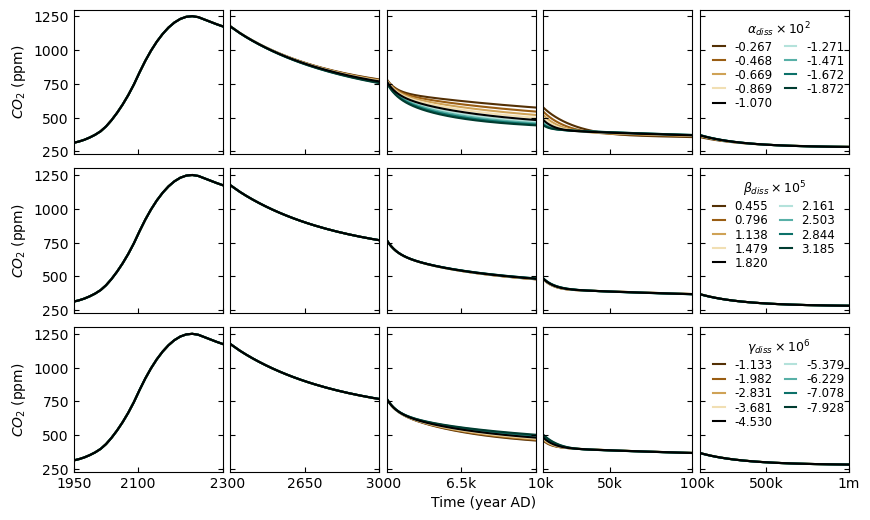

In [87]:
labels = [r'$\alpha_{diss} \times 10^2$',
          r'$\beta_{diss} \times 10^5$',
          r'$\gamma_{diss} \times 10^6$']
fig = sensitivity_plot(['alpha_diss','beta_diss','gamma_diss'],labels,np.linspace(0.25,1.75,9),[10**2,10**5,10**6],3)

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_acc.pdf'),bbox_inches='tight')

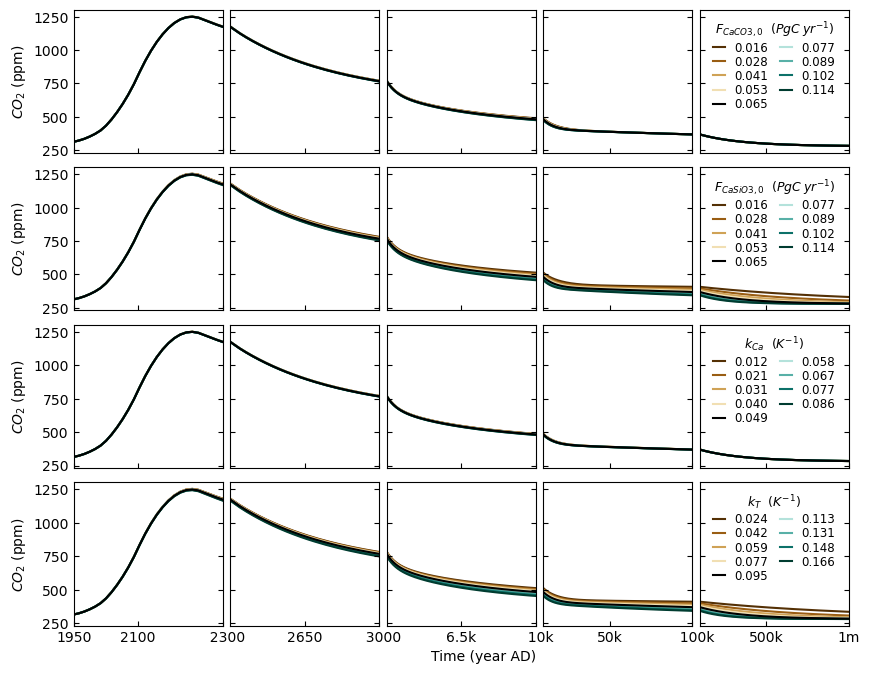

In [88]:
labels = [r'$F_{CaCO3,0}$  ($PgC\:yr^{-1}$)',
          r'$F_{CaSiO3,0}$  ($PgC\:yr^{-1}$)',
          r'$k_{Ca}$  ($K^{-1}$)',
          r'$k_{T}$  ($K^{-1}$)']
fig = sensitivity_plot(['F_CaCO3_pi','F_CaSiO3_pi','K_Ca','K_T'],labels,np.linspace(0.25,1.75,9),[1,1,1,1],3)

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_weathering.pdf'),bbox_inches='tight')

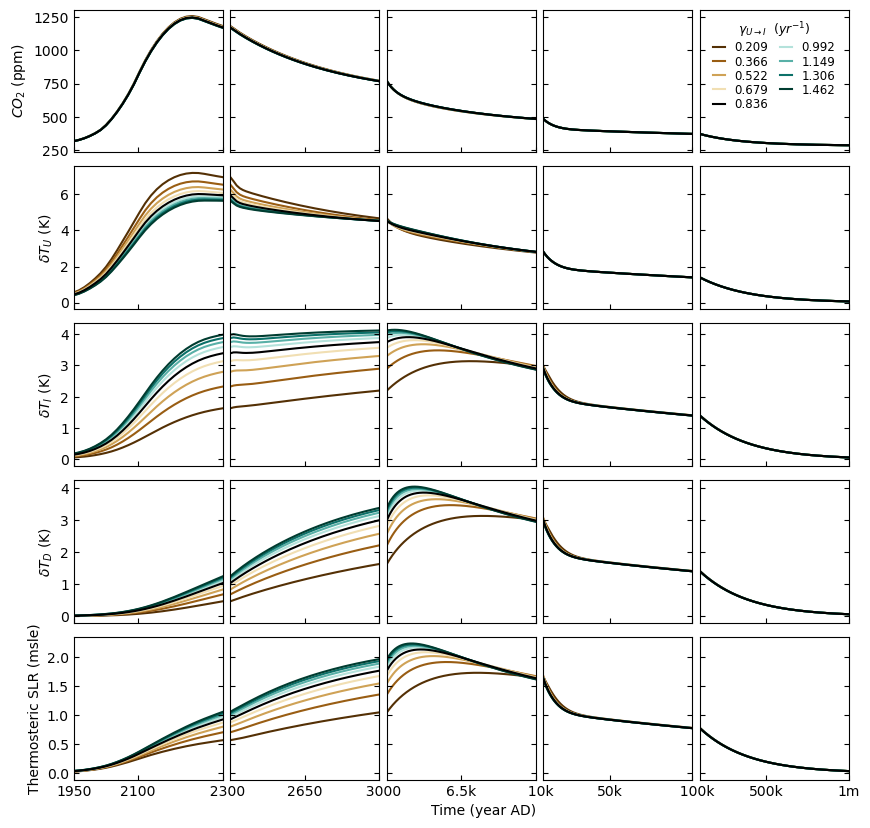

In [89]:
param = 'gamma_UI'
label = r'$\gamma_{U\rightarrow I}$  ($yr^{-1}$)'
param_mod = np.linspace(0.25,1.75,9)
scaling_factor = [1,1,1,1,1]
ssp_index = 3

nrows = 5
gs_kw = dict(width_ratios=[1,1,1,1,1],height_ratios=np.ones(nrows))
fig, axes = plt.subplots(nrows,5, figsize=(10,2*nrows),gridspec_kw=gs_kw, sharex='col')
teval=np.logspace(np.log10(1750),6,1000)
targetColors = cmap(np.linspace(0,1,len(param_mod)))



for j in range(0,len(param_mod)) :

    params_SURFER, mod_param_value = mod_params(param,param_mod[j])
    DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A,params_SURFER[0],params_SURFER[1],params_SURFER[6])
    MU_pi_mod = DIC_U*WU*carbon_molar_mass*10**-18
    y0 = [MA_pi,ML_pi,MU_pi_mod,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]

    params_SURFER[9]=params_SURFER[7]  # K_alk_UI = K_UI
    params_SURFER[10]=params_SURFER[8] # K_alk_DI = K_DI

    if (params_SURFER[13]+params_SURFER[14]<1) and (params_SURFER[15]+params_SURFER[16]<1) :
        
        sol = SURFER(emissions_ssp(ssp_index),y0,teval,params_SURFER,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

        for k in range(0,5):

            zzorder= 0
            if j == 4 : 
                color_choice = 'k'
                zzorder = 15
            else : color_choice = targetColors[j]

            thermosteric_slr = (sol.y[9]*alpha_U*hu+sol.y[10]*alpha_I*hi+sol.y[11]*alpha_D*hd)
            
            axes[0,k].plot(sol.t,PgCtoppm(sol.y[0]),color=color_choice,zorder=zzorder,label=r'%.3f'%(mod_param_value))
            axes[1,k].plot(sol.t,sol.y[9],color=color_choice,zorder=zzorder)
            axes[2,k].plot(sol.t,sol.y[10],color=color_choice,zorder=zzorder)
            axes[3,k].plot(sol.t,sol.y[11],color=color_choice,zorder=zzorder)
            axes[4,k].plot(sol.t,thermosteric_slr,color=color_choice,zorder=zzorder)

axes[0,0].set_xlim((1950,2300))    
axes[0,1].set_xlim((2300,3000))
axes[0,2].set_xlim((3000,10000))
axes[0,3].set_xlim((10000,100000))
axes[0,4].set_xlim((100000,1000000))

for k in range(0,nrows):
    axes[k,0].tick_params(direction = 'in',right=True)# don't put tick labels at the top
    
    
    for m in range(1,5):

        axes[k,m].tick_params(direction = 'in',right = True)# don't put tick labels at the top
        axes[k,m].tick_params(labelleft=False)

axes[0,4].legend(title = label,title_fontsize=9,loc='upper left',bbox_to_anchor =(0.02,0.02,0.98,0.98),fontsize=8.5,labelspacing = 0.1, ncol = 2,handlelength = 1, edgecolor = 'none',facecolor='none', columnspacing = 1) 

axes[0,0].set_ylabel(r'$CO_2$ (ppm)')
axes[1,0].set_ylabel(r'$\delta T_U$ (K)')
axes[2,0].set_ylabel(r'$\delta T_I$ (K)')
axes[3,0].set_ylabel(r'$\delta T_D$ (K)')
axes[4,0].set_ylabel(r'Thermosteric SLR (msle)')

axes[nrows-1,0].set_xticks([1950,2100,2300])
axes[nrows-1,0].set_xticklabels(['1950','2100','  2300'])
axes[nrows-1,1].set_xticks([2650,3000])
axes[nrows-1,1].set_xticklabels(['2650','  3000'])
axes[nrows-1,2].set_xticks([6500,10000])
axes[nrows-1,2].set_xticklabels(['6.5k','  10k'])
axes[nrows-1,3].set_xticks([50000,100000])
axes[nrows-1,3].set_xticklabels(['50k','  100k'])
axes[nrows-1,4].set_xticks([500000,1000000])
axes[nrows-1,4].set_xticklabels(['500k','1m'])

axes[nrows-1,2].set_xlabel(r'Time (year AD)',loc='right')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_gamma1.pdf'),bbox_inches='tight')

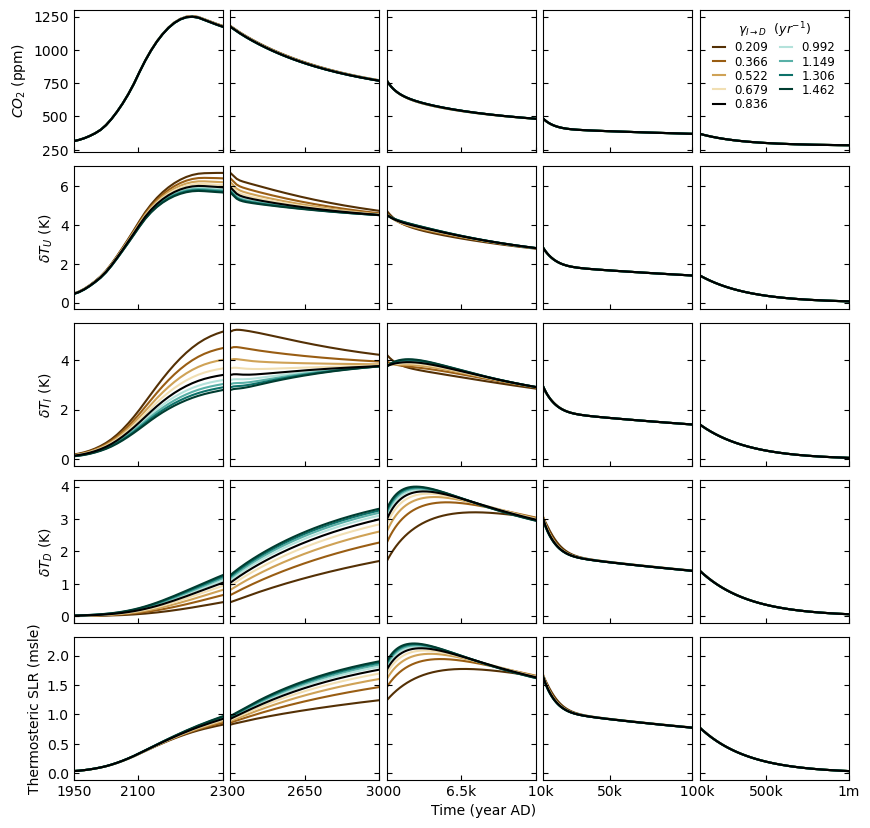

In [90]:
param = 'gamma_ID'
label = r'$\gamma_{I\rightarrow D}$  ($yr^{-1}$)'
param_mod = np.linspace(0.25,1.75,9)
scaling_factor = [1,1,1,1,1]
ssp_index = 3

nrows = 5
gs_kw = dict(width_ratios=[1,1,1,1,1],height_ratios=np.ones(nrows))
fig, axes = plt.subplots(nrows,5, figsize=(10,2*nrows),gridspec_kw=gs_kw, sharex='col')
teval=np.logspace(np.log10(1750),6,1000)
targetColors = cmap(np.linspace(0,1,len(param_mod)))



for j in range(0,len(param_mod)) :

    params_SURFER, mod_param_value = mod_params(param,param_mod[j])
    DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A,params_SURFER[0],params_SURFER[1],params_SURFER[6])
    MU_pi_mod = DIC_U*WU*carbon_molar_mass*10**-18
    y0 = [MA_pi,ML_pi,MU_pi_mod,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]

    params_SURFER[9]=params_SURFER[7]  # K_alk_UI = K_UI
    params_SURFER[10]=params_SURFER[8] # K_alk_DI = K_DI

    if (params_SURFER[13]+params_SURFER[14]<1) and (params_SURFER[15]+params_SURFER[16]<1) :
        
        sol = SURFER(emissions_ssp(ssp_index),y0,teval,params_SURFER,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

        for k in range(0,5):

            zzorder= 0
            if j == 4 : 
                color_choice = 'k'
                zzorder = 15
            else : color_choice = targetColors[j]

            thermosteric_slr = (sol.y[9]*alpha_U*hu+sol.y[10]*alpha_I*hi+sol.y[11]*alpha_D*hd)
            
            axes[0,k].plot(sol.t,PgCtoppm(sol.y[0]),color=color_choice,zorder=zzorder,label=r'%.3f'%(mod_param_value))
            axes[1,k].plot(sol.t,sol.y[9],color=color_choice,zorder=zzorder)
            axes[2,k].plot(sol.t,sol.y[10],color=color_choice,zorder=zzorder)
            axes[3,k].plot(sol.t,sol.y[11],color=color_choice,zorder=zzorder)
            axes[4,k].plot(sol.t,thermosteric_slr,color=color_choice,zorder=zzorder)

axes[0,0].set_xlim((1950,2300))    
axes[0,1].set_xlim((2300,3000))
axes[0,2].set_xlim((3000,10000))
axes[0,3].set_xlim((10000,100000))
axes[0,4].set_xlim((100000,1000000))

for k in range(0,nrows):
    axes[k,0].tick_params(direction = 'in',right=True)# don't put tick labels at the top
    
    
    for m in range(1,5):

        axes[k,m].tick_params(direction = 'in',right = True)# don't put tick labels at the top
        axes[k,m].tick_params(labelleft=False)

axes[0,4].legend(title = label,title_fontsize=9,loc='upper left',bbox_to_anchor =(0.02,0.02,0.98,0.98),fontsize=8.5,labelspacing = 0.1, ncol = 2,handlelength = 1, edgecolor = 'none',facecolor='none', columnspacing = 1) 

axes[0,0].set_ylabel(r'$CO_2$ (ppm)')
axes[1,0].set_ylabel(r'$\delta T_U$ (K)')
axes[2,0].set_ylabel(r'$\delta T_I$ (K)')
axes[3,0].set_ylabel(r'$\delta T_D$ (K)')
axes[4,0].set_ylabel(r'Thermosteric SLR (msle)')

axes[nrows-1,0].set_xticks([1950,2100,2300])
axes[nrows-1,0].set_xticklabels(['1950','2100','  2300'])
axes[nrows-1,1].set_xticks([2650,3000])
axes[nrows-1,1].set_xticklabels(['2650','  3000'])
axes[nrows-1,2].set_xticks([6500,10000])
axes[nrows-1,2].set_xticklabels(['6.5k','  10k'])
axes[nrows-1,3].set_xticks([50000,100000])
axes[nrows-1,3].set_xticklabels(['50k','  100k'])
axes[nrows-1,4].set_xticks([500000,1000000])
axes[nrows-1,4].set_xticklabels(['500k','1m'])

axes[nrows-1,2].set_xlabel(r'Time (year AD)',loc='right')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_gamma2.pdf'),bbox_inches='tight')

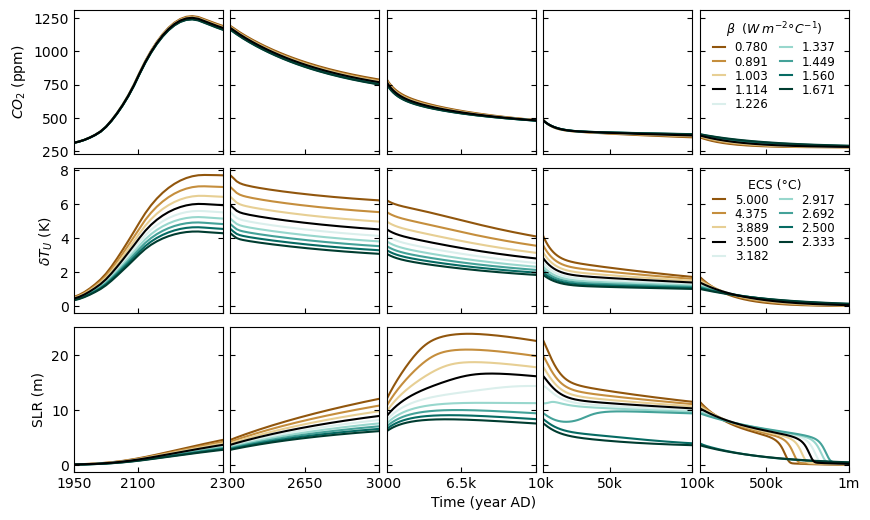

In [91]:
param = 'beta'
label = r'$\beta$  ($W\:m^{-2} °C^{-1}$)'
param_mod = np.linspace(0.7,1.5,9)
scaling_factor = [1,1,1,1,1]
ssp_index = 3

nrows = 3
gs_kw = dict(width_ratios=[1,1,1,1,1],height_ratios=np.ones(nrows))
fig, axes = plt.subplots(nrows,5, figsize=(10,2*nrows),gridspec_kw=gs_kw, sharex='col')
teval=np.logspace(np.log10(1750),6,1000)
targetColors = cmap(np.linspace(0,1,len(param_mod)+1))



for j in range(0,len(param_mod)) :

    params_SURFER, mod_param_value = mod_params(param,param_mod[j])
    DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A,params_SURFER[0],params_SURFER[1],params_SURFER[6])
    MU_pi_mod = DIC_U*WU*carbon_molar_mass*10**-18
    y0 = [MA_pi,ML_pi,MU_pi_mod,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]

    params_SURFER[9]=params_SURFER[7]  # K_alk_UI = K_UI
    params_SURFER[10]=params_SURFER[8] # K_alk_DI = K_DI

    if (params_SURFER[13]+params_SURFER[14]<1) and (params_SURFER[15]+params_SURFER[16]<1) :
        
        sol = SURFER(emissions_ssp(ssp_index),y0,teval,params_SURFER,IS_params,interp_sol=True,ktemp = True, sediments=True,weathering = True)

        for k in range(0,5):

            zzorder= 0
            if j == 3 : 
                color_choice = 'k'
                zzorder = 15
            else : color_choice = targetColors[j+1]

            ecs = fco2/mod_param_value
            
            axes[0,k].plot(sol.t,PgCtoppm(sol.y[0]),color=color_choice,zorder=zzorder,label=r'%.3f'%(mod_param_value))
            axes[1,k].plot(sol.t,sol.y[9],color=color_choice,zorder=zzorder,label=r'%.3f'%ecs)
            axes[2,k].plot(sol.t,SLR(sol),color=color_choice,zorder=zzorder)
          
axes[0,0].set_xlim((1950,2300))    
axes[0,1].set_xlim((2300,3000))
axes[0,2].set_xlim((3000,10000))
axes[0,3].set_xlim((10000,100000))
axes[0,4].set_xlim((100000,1000000))

for k in range(0,nrows):
    axes[k,0].tick_params(direction = 'in',right=True)# don't put tick labels at the top
    
    
    for m in range(1,5):

        axes[k,m].tick_params(direction = 'in',right = True)# don't put tick labels at the top
        axes[k,m].tick_params(labelleft=False)

axes[0,4].legend(title = label,title_fontsize=9,loc='upper left',bbox_to_anchor =(0.02,0.02,0.98,0.98),fontsize=8.5,labelspacing = 0.1, ncol = 2,handlelength = 1, edgecolor = 'none',facecolor='none', columnspacing = 1) 
axes[1,4].legend(title = r'ECS (°C)',title_fontsize=9,loc='upper left',bbox_to_anchor =(0.02,0.02,0.98,0.98),fontsize=8.5,labelspacing = 0.1, ncol = 2,handlelength = 1, edgecolor = 'none',facecolor='none', columnspacing = 1) 


axes[0,0].set_ylabel(r'$CO_2$ (ppm)')
axes[1,0].set_ylabel(r'$\delta T_U$ (K)')
axes[2,0].set_ylabel(r'SLR (m)')

axes[nrows-1,0].set_xticks([1950,2100,2300])
axes[nrows-1,0].set_xticklabels(['1950','2100','  2300'])
axes[nrows-1,1].set_xticks([2650,3000])
axes[nrows-1,1].set_xticklabels(['2650','  3000'])
axes[nrows-1,2].set_xticks([6500,10000])
axes[nrows-1,2].set_xticklabels(['6.5k','  10k'])
axes[nrows-1,3].set_xticks([50000,100000])
axes[nrows-1,3].set_xticklabels(['50k','  100k'])
axes[nrows-1,4].set_xticks([500000,1000000])
axes[nrows-1,4].set_xticklabels(['500k','1m'])

axes[nrows-1,2].set_xlabel(r'Time (year AD)',loc='right')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

# Uncomment next line to save figure in the defined repository (see Setup)
# fig.savefig(os.path.join(figures_path, 'sensitivity_ecs.pdf'),bbox_inches='tight')